<a href="https://colab.research.google.com/github/Keshavkant02/Projects-/blob/main/TBI_project_UNET.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Intracranial Hemorrhage Segmentation using U-Net (Prototype)

**Goal:** Develop and train a prototype U-Net model using TensorFlow/Keras to perform semantic segmentation of intracranial hemorrhage (ICH) regions on brain CT scan slices. This project serves as a demonstration of applying deep learning to medical image analysis, including data loading, preprocessing, model building, training, and evaluation.

**Dataset:** [Computed Tomography Images for Intracranial Hemorrhage Detection and Segmentation](https://www.kaggle.com/datasets/vbookshelf/computed-tomography-ct-images) dataset from Kaggle.
*   Format: Grayscale brain CT slices saved as JPG images. Corresponding segmentation masks (showing hemorrhage regions) also saved as JPG images (`_HGE_Seg.jpg`).
*   Source: Hssayeni et al. (See dataset description for details).

**Key Tools:** Python, TensorFlow (Keras API), NumPy, Matplotlib, Scikit-image, Scikit-learn, Kaggle API.

**Outcome Summary:** Successfully implemented a data loading pipeline, overcoming path and mask processing challenges. Trained a basic U-Net model for a small number of epochs, demonstrating the feasibility of the approach. Visualized training progress and sample segmentation results on validation data. Further improvements (longer training, augmentation, etc.) are outlined in the final section.

## 1. Setup: Installing Libraries

This first step installs the necessary Python libraries required for the project. We need tools for:
*   **`tensorflow`**: The core deep learning framework (we'll use its Keras API).
*   **`kaggle`**: To interact with the Kaggle API for downloading the dataset.
*   **`pydicom` / `SimpleITK`**: Although the final dataset used JPGs, these are standard libraries for handling medical DICOM files (kept here for potential future use or demonstrating awareness).
*   **`numpy`**: Fundamental library for numerical operations and handling image data as arrays.
*   **`matplotlib` / `seaborn`**: For plotting graphs and visualizing images/masks.
*   **`scikit-image`**: Provides image processing functions like resizing.
*   **`scikit-learn`**: Useful for helper functions like splitting data (`train_test_split`).
*   **`pandas`**: Generally useful for handling metadata (though less used in this specific version).
*   **`tqdm`**: Creates progress bars for loops, making lengthy operations easier to monitor.

In [17]:
#------------------------------------
# Cell 1: Install Necessary Libraries
#------------------------------------
!pip install pydicom tensorflow matplotlib scikit-image SimpleITK pandas tqdm kaggle scikit-learn

print("Libraries installed!")

Libraries installed!


## 2. Setup: Importing Libraries

Here, we import the specific modules and functions we'll need from the installed libraries into our Python environment. This makes them ready to use in the subsequent code cells.

In [18]:
#------------------------------------
# Cell 2: Import Libraries
#------------------------------------
import os
import glob # For finding files
import zipfile # For unzipping datasets
import numpy as np
import pandas as pd
import pydicom # For reading DICOM files
import SimpleITK as sitk # Can also read DICOM and NIfTI, often more robust
from skimage.transform import resize # For resizing images/masks
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from sklearn.model_selection import train_test_split
from tqdm import tqdm # Progress bar

print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.18.0


## 3. Setup: Configuring Kaggle API Access

To download the dataset directly from Kaggle into this Colab environment, we need to provide authentication credentials.
1.  **Upload `kaggle.json`**: This file (downloaded from your Kaggle account settings) contains your unique API username and key. It must be uploaded using the Colab file browser *before* running this cell.
2.  **Copy and Secure**: The code then copies this `kaggle.json` file to the location where the Kaggle API tool expects to find it (`~/.kaggle/`) and sets the correct file permissions (`chmod 600`) for security.

*Note: This step needs to be repeated every time the Colab runtime restarts (e.g., due to inactivity or switching hardware accelerators).*

In [19]:
#------------------------------------
# Cell 3: Kaggle API Setup
#------------------------------------
# IMPORTANT: Upload your 'kaggle.json' file using the Colab file browser (folder icon on the left)
# before running this cell.

# Create a directory for the Kaggle configuration
!mkdir -p ~/.kaggle
# Move the uploaded kaggle.json file to the required directory
!cp kaggle.json ~/.kaggle/
# Set permissions for the file
!chmod 600 ~/.kaggle/kaggle.json

print("Kaggle API configured.")

Kaggle API configured.


## 4. Data Acquisition: Downloading and Unzipping the Dataset

This cell handles fetching the data from Kaggle.
1.  **Dataset Identifier**: We specify the unique Kaggle dataset path (`vbookshelf/computed-tomography-ct-images`).
2.  **Download**: It uses the `kaggle datasets download` command to get the data as a zip file. It includes a check to avoid re-downloading if the zip file already exists.
3.  **Unzip**: If the zip file exists and the target directory (`./dataset`) doesn't, it extracts the contents using Python's `zipfile` library.
4.  **Path Definition & Verification**: It sets the `DATA_DIR` variable and performs an initial check to see if the expected subfolder structure (`Patients_CT`) exists, warning the user if it doesn't (as we discovered during debugging!).

*Challenge Faced Here: Initially, the unzipped data had an extra parent folder. We later adjusted the path used in Cell 7 to account for this.*

In [20]:
#------------------------------------
# Cell 4: Download and Unzip Dataset
#------------------------------------
import os
import zipfile # Make sure zipfile is imported if not done earlier

# --- Step 1: Define the Kaggle Dataset Identifier ---
# This is the 'username/dataset-name' string for the dataset you want.
KAGGLE_DATASET_STRING = 'vbookshelf/computed-tomography-ct-images' # Correct identifier

# --- Step 2: Define the Expected Zip Filename ---
# The kaggle API usually downloads the zip file named after the dataset part.
EXPECTED_ZIP_FILENAME = KAGGLE_DATASET_STRING.split('/')[-1] + '.zip'
# In this case: 'computed-tomography-ct-images.zip'

# --- Step 3: Define Where to Unzip ---
UNZIP_DIR = './dataset' # Directory to extract files into

# --- Step 4: Check if Download is Needed ---
if not os.path.exists(EXPECTED_ZIP_FILENAME):
    print(f"Downloading dataset: {KAGGLE_DATASET_STRING}...")
    # Use the identifier string directly in the download command
    !kaggle datasets download -d {KAGGLE_DATASET_STRING}
    print("Download complete.")
    # Add a check to ensure the download actually created the file
    if not os.path.exists(EXPECTED_ZIP_FILENAME):
         raise FileNotFoundError(f"ERROR: Kaggle download command ran, but expected zip file '{EXPECTED_ZIP_FILENAME}' was not found. Check for download errors above.")
else:
    print(f"Dataset zip file '{EXPECTED_ZIP_FILENAME}' already exists.")

# --- Step 5: Check if Unzipping is Needed ---
if os.path.exists(EXPECTED_ZIP_FILENAME) and not os.path.exists(UNZIP_DIR):
    print(f"Unzipping {EXPECTED_ZIP_FILENAME} into {UNZIP_DIR}...")
    try:
        with zipfile.ZipFile(EXPECTED_ZIP_FILENAME, 'r') as zip_ref:
            zip_ref.extractall(UNZIP_DIR)
        print(f"Dataset extracted to {UNZIP_DIR}")
    except zipfile.BadZipFile:
        print(f"ERROR: Failed to unzip '{EXPECTED_ZIP_FILENAME}'. File might be corrupted or download incomplete.")
        # Optionally, try deleting the bad zip file so it redownloads next time
        # os.remove(EXPECTED_ZIP_FILENAME)
    except Exception as e:
        print(f"ERROR: An unexpected error occurred during unzipping: {e}")

elif os.path.exists(UNZIP_DIR):
    print(f"Dataset directory '{UNZIP_DIR}' already exists. Skipping unzipping.")
elif not os.path.exists(EXPECTED_ZIP_FILENAME):
     print(f"ERROR: Cannot unzip because zip file '{EXPECTED_ZIP_FILENAME}' was not found. Check download step.")

# --- Step 6: Define DATA_DIR for later use (if unzipping was successful or dir already exists) ---
if os.path.exists(UNZIP_DIR):
    DATA_DIR = UNZIP_DIR # Base directory for the extracted data
    print(f"DATA_DIR set to: {DATA_DIR}")
    # --- IMPORTANT: Verify Structure ---
    # Add a check for the expected subfolder based on the dataset description
    EXPECTED_SUBFOLDER = os.path.join(DATA_DIR, 'Patients_CT') # Check if this folder exists after unzipping
    if os.path.exists(EXPECTED_SUBFOLDER) and os.path.isdir(EXPECTED_SUBFOLDER):
        print(f"Verified: Expected subfolder '{EXPECTED_SUBFOLDER}' found.")
    else:
        print(f"WARNING: Expected subfolder '{EXPECTED_SUBFOLDER}' NOT found inside {DATA_DIR}. ")
        print(f"Please check the actual contents of {DATA_DIR} using the Colab file browser.")
        print("You will need to adjust DATA_ROOT in Cell 7 accordingly.")

else:
    DATA_DIR = None
    print(f"ERROR: Data directory '{UNZIP_DIR}' could not be confirmed. Subsequent cells might fail.")

Dataset zip file 'computed-tomography-ct-images.zip' already exists.
Dataset directory './dataset' already exists. Skipping unzipping.
DATA_DIR set to: ./dataset
Please check the actual contents of ./dataset using the Colab file browser.
You will need to adjust DATA_ROOT in Cell 7 accordingly.


## 5. Configuration: Defining Constants and Parameters

This cell defines key parameters that control the data processing and model training:
*   `IMG_HEIGHT`, `IMG_WIDTH`: The target size (in pixels) to which all images and masks will be resized. This ensures consistent input for the model. We started with 128x128 for computational efficiency.
*   `IMG_CHANNELS`: Set to 1 for grayscale images.
*   `VALIDATION_SPLIT`: The proportion (10%) of the data reserved for the validation set (to evaluate the model on unseen data).
*   `EPOCHS`, `BATCH_SIZE`: Training parameters (defined later or defaulted in Cell 10) controlling how long and how the model trains.

In [21]:
#------------------------------------
# Cell 5: Define Constants and Parameters
#------------------------------------
IMG_HEIGHT = 128 # Resize images to this height (adjust based on GPU memory)
IMG_WIDTH = 128  # Resize images to this width
IMG_CHANNELS = 1 # Grayscale images

# CT Windowing Parameters (Brain Window) - Adjust if needed


# Training Parameters (Keep small for initial testing)
EPOCHS = 5 # Start with few epochs
BATCH_SIZE = 16 # Adjust based on GPU memory and image size
VALIDATION_SPLIT = 0.1 # Use 10% of data for validation

# --- !!! USER ACTION REQUIRED !!! ---
# Adjust these paths based on your UNZIPPED dataset structure (see Cell 4 output)
# Example: If DICOMs are in './dataset/images' and masks in './dataset/masks'


## 6. Data Preprocessing: Helper Functions

To keep the main loading loop clean, we define reusable helper functions here:

*   **`preprocess_image`**: Takes a raw image array, resizes it to the target dimensions (`IMG_HEIGHT`, `IMG_WIDTH`), normalizes its pixel values from the original 0-255 range to 0.0-1.0 (standard practice for neural networks), and adds a channel dimension required by Keras.
*   **`load_mask`**: Takes the path to a mask file (`_HGE_Seg.jpg`), reads it, handles potential grayscale conversion, resizes it using *nearest neighbor* interpolation (crucial to keep mask values binary 0/1 without blurring), thresholds the resized mask to ensure strict binary output (0.0 or 1.0), and adds the channel dimension.
    *   *Challenge Faced Here: Significant debugging was needed for the thresholding step. We verified raw mask values were 0-255 and adjusted the threshold logic (`> 128`) to correctly convert the white areas (255) to 1.0 after resizing.*
*   **`dice_coef` / `dice_loss`**: Defines the Dice Coefficient metric (measures overlap between predicted and true masks, higher is better) and the corresponding Dice Loss (1 - Dice Coefficient, which the model tries to minimize during training). These are standard choices for segmentation tasks, especially with potential class imbalance.

In [22]:
#------------------------------------
# Cell 6: Helper Functions
#------------------------------------
import numpy as np                 # Make sure numpy is imported
from skimage.transform import resize # Make sure resize is imported
import matplotlib.pyplot as plt    # Make sure plt is imported
import tensorflow as tf            # Make sure tensorflow is imported

def preprocess_image(image, target_height, target_width):
    """
    Resizes and normalizes a grayscale JPG image (assumed range 0-255) to [0, 1].
    """
    # 1. Ensure image is float32 for processing
    image = image.astype(np.float32)

    # 2. Resize
    # Keep range 0-255 during resize using preserve_range=True
    image_resized = resize(image, (target_height, target_width), anti_aliasing=True, mode='constant', preserve_range=True)

    # 3. Normalize to [0, 1] by dividing by 255
    image_normalized = image_resized / 255.0
    image_normalized = np.clip(image_normalized, 0, 1) # Ensure values are strictly within [0, 1]

    # 4. Add channel dimension for Keras (Height, Width, Channels=1)
    return image_normalized[:, :, np.newaxis]

def load_mask(path, target_height, target_width):
    """
    Loads a mask image (JPG/PNG etc), resizes using nearest neighbor,
    ensures it's binary (0 or 1), and adds a channel dimension.
    """
    try:
        mask = plt.imread(path)
        if len(mask.shape) == 3 and mask.shape[-1] != 1:
             if np.allclose(mask[..., 0], mask[..., 1]) and np.allclose(mask[..., 1], mask[..., 2]):
                  mask = mask[..., 0]
             else: mask = mask.mean(axis=-1)

        # Ensure mask is float for processing before resize/threshold
        mask = mask.astype(np.float32)

        # Resize mask
        mask_resized = resize(mask, (target_height, target_width), order=0, anti_aliasing=False, preserve_range=True, mode='constant')

        # --- DEBUG PRINT INSIDE load_mask ---
        print(f"    DEBUG load_mask - Resized min: {np.min(mask_resized):.1f}, max: {np.max(mask_resized):.1f}, dtype: {mask_resized.dtype}")
        # --- END DEBUG ---

        # Direct thresholding on the resized (should be ~0-255 float) mask
        mask_binary = (mask_resized > 128).astype(np.float32) # Use 128 threshold for uint8 0-255 range

        return mask_binary[:, :, np.newaxis]
    except Exception as e:
        print(f"Error loading mask {path}: {e}")
        return None

        # Ensure mask is float for processing before resize/threshold
        mask = mask.astype(np.float32)

        # Resize mask - IMPORTANT: use nearest neighbor interpolation (order=0) for masks!
        # preserve_range=True ensures 0-255 range is kept if applicable before thresholding
        mask_resized = resize(mask, (target_height, target_width), order=0, anti_aliasing=False, preserve_range=True, mode='constant')

        # Alternative: Normalize the resized 0-255 mask to 0-1 range FIRST
        mask_resized_normalized = mask_resized / 255.0
        # THEN threshold at 0.5
        mask_binary = (mask_resized_normalized > 0.5).astype(np.float32)

        # Add channel dimension
        return mask_binary[:, :, np.newaxis]
    except Exception as e:
        print(f"Error loading mask {path}: {e}")
        return None

# Dice Coefficient Metric Function
def dice_coef(y_true, y_pred, smooth=1e-6):
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    denominator = tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f)
    return (2. * intersection + smooth) / (denominator + smooth)

# Dice Loss Function
def dice_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred) # Ensure float calculation

print("Helper functions defined.")

Helper functions defined.


## 7. Data Loading and Preparation Loop

This is the core data preparation step where we iterate through the dataset folders and prepare the images and masks for the model.

1.  **Path Definition**: Sets the correct `DATA_ROOT` path, pointing to the `Patients_CT` folder (incorporating the fix for the extra directory layer found during debugging).
2.  **Find Patients**: Uses `glob` to find all patient subfolders.
3.  **Loop Patients/Slices**: Iterates through each patient and then through each numbered image slice (`.jpg`) within their `brain` subfolder.
4.  **Load Image**: Reads the image slice using `matplotlib.pyplot.imread`.
5.  **Preprocess Image**: Calls the `preprocess_image` helper function (from Cell 6).
6.  **Find & Load Mask**:
    *   Constructs the expected mask filename using the slice number and the correct `_HGE_Seg.jpg` pattern (identified during debugging).
    *   Checks if this mask file actually exists using `os.path.exists`.
    *   If it exists, calls the `load_mask` helper function (from Cell 6).
    *   If it *doesn't* exist, creates a blank mask (an array of all zeros) of the target size. This ensures every image has a corresponding mask, even if it's empty.
7.  **Append Data**: Appends the processed image (`img_processed`) and the corresponding processed mask (`mask_processed`, either loaded or blank) to the `X_data` and `Y_data` lists.
8.  **Convert to NumPy Arrays**: After looping through all files, converts the lists of individual arrays into large, single NumPy arrays. This is the standard format for feeding data into TensorFlow/Keras.
9.  **Final Checks**: Prints the shapes of the final arrays and verifies that non-empty masks were successfully loaded (this check failed until the `load_mask` thresholding was fixed).
10. **Split Data**: Uses `train_test_split` from Scikit-learn to divide `X_data` and `Y_data` into training and validation sets based on the `VALIDATION_SPLIT` fraction.

In [11]:
#------------------------------------
# Cell 7: Data Loading Loop (Final Debug Check After np.array)
#------------------------------------
import os                          # Ensure os is imported
import glob                        # Ensure glob is imported
import numpy as np                 # Ensure numpy is imported
import matplotlib.pyplot as plt    # Ensure plt is imported (used in load_mask)
from tqdm import tqdm              # Ensure tqdm is imported
from sklearn.model_selection import train_test_split # Ensure splitting function is imported

# --- Define Constants (ensure these are consistent if also defined in Cell 5) ---
IMG_HEIGHT = 128
IMG_WIDTH = 128
VALIDATION_SPLIT = 0.1 # Use 10% of data for validation

# --- Define the CORRECT path to the Patients_CT folder ---
DATA_ROOT = './dataset/computed-tomography-images-for-intracranial-hemorrhage-detection-and-segmentation-1.0.0/Patients_CT'

X_data = []
Y_data = []

print(f"Scanning patient folders in: {DATA_ROOT}")
patient_folders = sorted(glob.glob(os.path.join(DATA_ROOT, '*')))

if not patient_folders:
     raise FileNotFoundError(f"No patient folders found in '{DATA_ROOT}'.")
else:
    print(f"Found {len(patient_folders)} patient folders. Processing...")

mask_files_found_count = 0

for patient_path in tqdm(patient_folders, desc="Processing Patients"):
    brain_folder = os.path.join(patient_path, 'brain')
    if not os.path.isdir(brain_folder): continue

    slice_paths = sorted(glob.glob(os.path.join(brain_folder, '[0-9]*.jpg')))
    if not slice_paths: continue

    for img_path in slice_paths:
        # --- Load and Preprocess Image ---
        try:
            img = plt.imread(img_path)
            if len(img.shape) == 3 and img.shape[-1] != 1:
                if np.allclose(img[..., 0], img[..., 1]) and np.allclose(img[..., 1], img[..., 2]):
                    img = img[..., 0]
                else: img = img.mean(axis=-1)
            if img is None: raise ValueError("Image loaded as None")
            img_processed = preprocess_image(img, IMG_HEIGHT, IMG_WIDTH) # Cell 6 func
        except Exception as e:
            print(f"\nError loading image {img_path}: {e}. Skipping.")
            continue

        # --- Find and Load/Process Mask ---
        slice_number = os.path.splitext(os.path.basename(img_path))[0]
        mask_filename = f"{slice_number}_HGE_Seg.jpg" # Correct filename with underscore
        mask_path = os.path.join(brain_folder, mask_filename)

        mask_processed = None # Initialize

        if os.path.exists(mask_path):
            mask_files_found_count += 1
            # --- Try loading and processing the found mask ---
            try:
                # Debug Prints for raw/processed values (includes internal print from load_mask now)
                print(f"\n>>> SUCCESS: Found mask file: {mask_path}")
                raw_mask_temp = plt.imread(mask_path) # Load temporarily for raw info
                print(f"    Raw shape: {raw_mask_temp.shape}, dtype: {raw_mask_temp.dtype}, min: {np.min(raw_mask_temp)}, max: {np.max(raw_mask_temp)}")

                mask_processed = load_mask(mask_path, IMG_HEIGHT, IMG_WIDTH) # Call Cell 6 func

                if mask_processed is not None:
                    print(f"    Processed min: {np.min(mask_processed):.1f}, max: {np.max(mask_processed):.1f}")
                    if np.max(mask_processed) == 0: print("    >>> WARNING: Processed mask is all zeros!")
                else: print("    >>> ERROR: load_mask returned None")

            except Exception as e_dbg:
                 print(f"    Error during mask loading/processing for {mask_path}: {e_dbg}")
                 mask_processed = None
        else:
            # Create a blank mask if no corresponding mask file exists
            mask_processed = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.float32)

        # --- Append Data ---
        # Only append if mask_processed is not None
        if mask_processed is not None:
             X_data.append(img_processed)
             Y_data.append(mask_processed)
        # else: (Error already handled/printed above)

# --- Final Checks and Splitting ---
if not X_data:
     raise ValueError("CRITICAL ERROR: No data was loaded into X_data.")

# Convert lists to NumPy arrays
X_data = np.array(X_data)
Y_data = np.array(Y_data) # <<< CONVERSION HAPPENS HERE

print("\n------------------------------------")
print(f"Data Loading Summary:")
print(f"Total image/mask pairs loaded: {len(X_data)}")
print(f"X_data shape: {X_data.shape}")
print(f"Y_data shape: {Y_data.shape}")
print(f">>> Total mask files physically found during run: {mask_files_found_count}") # Moved this here

# --- NEW DEBUG CHECK AFTER np.array CONVERSION ---
# Check sum of first ~10 masks in the final Y_data array
print("\n--- DEBUG CHECK POST-CONVERSION ---")
num_check = min(len(Y_data), 10) # Check up to 10 or total length if less
if num_check > 0:
     print(f"DEBUG: Sums of first {num_check} masks in final Y_data array (axis 1,2,3):")
     print(np.sum(Y_data[:num_check], axis=(1, 2, 3)))
else:
    print("DEBUG: Y_data is empty, cannot check sums.")
print("--- END DEBUG CHECK ---")
# --- END NEW DEBUG CHECK ---


# Original final check (Now compare this to the debug check above)
non_empty_masks = np.sum(Y_data, axis=(1, 2)) > 0 # Sum over H, W dims only for boolean check
print(f"\nNumber of non-empty masks loaded (final check on boolean): {np.sum(non_empty_masks)}")

if np.sum(non_empty_masks) == 0 and len(X_data) > 0:
    print("WARNING: Final check shows all masks are empty despite earlier 'GOOD' messages. Check conversion/final check logic.")

# --- Split Data ---
X_train, X_val, Y_train, Y_val = train_test_split(X_data, Y_data, test_size=VALIDATION_SPLIT, random_state=42)

print("\nData Splitting Summary:")
print(f"Training data shape (X_train): {X_train.shape}")
print(f"Training labels shape (Y_train): {Y_train.shape}")
print(f"Validation data shape (X_val): {X_val.shape}")
print(f"Validation labels shape (Y_val): {Y_val.shape}")
print("------------------------------------")

Scanning patient folders in: ./dataset/computed-tomography-images-for-intracranial-hemorrhage-detection-and-segmentation-1.0.0/Patients_CT
Found 82 patient folders. Processing...


Processing Patients:   0%|          | 0/82 [00:00<?, ?it/s]


>>> SUCCESS: Found mask file: ./dataset/computed-tomography-images-for-intracranial-hemorrhage-detection-and-segmentation-1.0.0/Patients_CT/049/brain/14_HGE_Seg.jpg
    Raw shape: (650, 650), dtype: uint8, min: 0, max: 255
    DEBUG load_mask - Resized min: 0.0, max: 255.0, dtype: float32
    Processed min: 0.0, max: 1.0

>>> SUCCESS: Found mask file: ./dataset/computed-tomography-images-for-intracranial-hemorrhage-detection-and-segmentation-1.0.0/Patients_CT/049/brain/15_HGE_Seg.jpg
    Raw shape: (650, 650), dtype: uint8, min: 0, max: 255
    DEBUG load_mask - Resized min: 0.0, max: 255.0, dtype: float32
    Processed min: 0.0, max: 1.0

>>> SUCCESS: Found mask file: ./dataset/computed-tomography-images-for-intracranial-hemorrhage-detection-and-segmentation-1.0.0/Patients_CT/049/brain/16_HGE_Seg.jpg
    Raw shape: (650, 650), dtype: uint8, min: 0, max: 255
    DEBUG load_mask - Resized min: 0.0, max: 255.0, dtype: float32
    Processed min: 0.0, max: 1.0

>>> SUCCESS: Found mask fil

Processing Patients:   1%|          | 1/82 [00:00<00:52,  1.55it/s]


>>> SUCCESS: Found mask file: ./dataset/computed-tomography-images-for-intracranial-hemorrhage-detection-and-segmentation-1.0.0/Patients_CT/049/brain/27_HGE_Seg.jpg
    Raw shape: (650, 650), dtype: uint8, min: 0, max: 255
    DEBUG load_mask - Resized min: 0.0, max: 255.0, dtype: float32
    Processed min: 0.0, max: 1.0

>>> SUCCESS: Found mask file: ./dataset/computed-tomography-images-for-intracranial-hemorrhage-detection-and-segmentation-1.0.0/Patients_CT/050/brain/15_HGE_Seg.jpg
    Raw shape: (650, 650), dtype: uint8, min: 0, max: 255
    DEBUG load_mask - Resized min: 0.0, max: 255.0, dtype: float32
    Processed min: 0.0, max: 1.0

>>> SUCCESS: Found mask file: ./dataset/computed-tomography-images-for-intracranial-hemorrhage-detection-and-segmentation-1.0.0/Patients_CT/050/brain/16_HGE_Seg.jpg
    Raw shape: (650, 650), dtype: uint8, min: 0, max: 255
    DEBUG load_mask - Resized min: 0.0, max: 255.0, dtype: float32
    Processed min: 0.0, max: 1.0

>>> SUCCESS: Found mask fil

Processing Patients:   2%|▏         | 2/82 [00:01<00:39,  2.01it/s]


>>> SUCCESS: Found mask file: ./dataset/computed-tomography-images-for-intracranial-hemorrhage-detection-and-segmentation-1.0.0/Patients_CT/050/brain/26_HGE_Seg.jpg
    Raw shape: (650, 650), dtype: uint8, min: 0, max: 255
    DEBUG load_mask - Resized min: 0.0, max: 255.0, dtype: float32
    Processed min: 0.0, max: 1.0

>>> SUCCESS: Found mask file: ./dataset/computed-tomography-images-for-intracranial-hemorrhage-detection-and-segmentation-1.0.0/Patients_CT/051/brain/14_HGE_Seg.jpg
    Raw shape: (650, 650), dtype: uint8, min: 0, max: 255
    DEBUG load_mask - Resized min: 0.0, max: 255.0, dtype: float32
    Processed min: 0.0, max: 1.0

>>> SUCCESS: Found mask file: ./dataset/computed-tomography-images-for-intracranial-hemorrhage-detection-and-segmentation-1.0.0/Patients_CT/051/brain/15_HGE_Seg.jpg
    Raw shape: (650, 650), dtype: uint8, min: 0, max: 255
    DEBUG load_mask - Resized min: 0.0, max: 255.0, dtype: float32
    Processed min: 0.0, max: 1.0

>>> SUCCESS: Found mask fil

Processing Patients:   4%|▎         | 3/82 [00:01<00:46,  1.71it/s]


>>> SUCCESS: Found mask file: ./dataset/computed-tomography-images-for-intracranial-hemorrhage-detection-and-segmentation-1.0.0/Patients_CT/051/brain/29_HGE_Seg.jpg
    Raw shape: (650, 650), dtype: uint8, min: 0, max: 255
    DEBUG load_mask - Resized min: 0.0, max: 255.0, dtype: float32
    Processed min: 0.0, max: 1.0

>>> SUCCESS: Found mask file: ./dataset/computed-tomography-images-for-intracranial-hemorrhage-detection-and-segmentation-1.0.0/Patients_CT/051/brain/30_HGE_Seg.jpg
    Raw shape: (650, 650), dtype: uint8, min: 0, max: 255
    DEBUG load_mask - Resized min: 0.0, max: 255.0, dtype: float32
    Processed min: 0.0, max: 1.0

>>> SUCCESS: Found mask file: ./dataset/computed-tomography-images-for-intracranial-hemorrhage-detection-and-segmentation-1.0.0/Patients_CT/051/brain/31_HGE_Seg.jpg
    Raw shape: (650, 650), dtype: uint8, min: 0, max: 255
    DEBUG load_mask - Resized min: 0.0, max: 255.0, dtype: float32
    Processed min: 0.0, max: 1.0

>>> SUCCESS: Found mask fil

Processing Patients:   5%|▍         | 4/82 [00:02<00:43,  1.78it/s]


>>> SUCCESS: Found mask file: ./dataset/computed-tomography-images-for-intracranial-hemorrhage-detection-and-segmentation-1.0.0/Patients_CT/053/brain/18_HGE_Seg.jpg
    Raw shape: (650, 650), dtype: uint8, min: 0, max: 255
    DEBUG load_mask - Resized min: 0.0, max: 255.0, dtype: float32
    Processed min: 0.0, max: 1.0

>>> SUCCESS: Found mask file: ./dataset/computed-tomography-images-for-intracranial-hemorrhage-detection-and-segmentation-1.0.0/Patients_CT/053/brain/19_HGE_Seg.jpg
    Raw shape: (650, 650), dtype: uint8, min: 0, max: 255
    DEBUG load_mask - Resized min: 0.0, max: 255.0, dtype: float32
    Processed min: 0.0, max: 1.0

>>> SUCCESS: Found mask file: ./dataset/computed-tomography-images-for-intracranial-hemorrhage-detection-and-segmentation-1.0.0/Patients_CT/053/brain/20_HGE_Seg.jpg
    Raw shape: (650, 650), dtype: uint8, min: 0, max: 255
    DEBUG load_mask - Resized min: 0.0, max: 255.0, dtype: float32
    Processed min: 0.0, max: 1.0

>>> SUCCESS: Found mask fil

Processing Patients:   6%|▌         | 5/82 [00:02<00:41,  1.87it/s]


>>> SUCCESS: Found mask file: ./dataset/computed-tomography-images-for-intracranial-hemorrhage-detection-and-segmentation-1.0.0/Patients_CT/053/brain/27_HGE_Seg.jpg
    Raw shape: (650, 650), dtype: uint8, min: 0, max: 255
    DEBUG load_mask - Resized min: 0.0, max: 255.0, dtype: float32
    Processed min: 0.0, max: 1.0

>>> SUCCESS: Found mask file: ./dataset/computed-tomography-images-for-intracranial-hemorrhage-detection-and-segmentation-1.0.0/Patients_CT/053/brain/28_HGE_Seg.jpg
    Raw shape: (650, 650), dtype: uint8, min: 0, max: 255
    DEBUG load_mask - Resized min: 0.0, max: 255.0, dtype: float32
    Processed min: 0.0, max: 1.0


Processing Patients:  11%|█         | 9/82 [00:05<00:55,  1.31it/s]


>>> SUCCESS: Found mask file: ./dataset/computed-tomography-images-for-intracranial-hemorrhage-detection-and-segmentation-1.0.0/Patients_CT/058/brain/13_HGE_Seg.jpg
    Raw shape: (650, 650), dtype: uint8, min: 0, max: 255
    DEBUG load_mask - Resized min: 0.0, max: 255.0, dtype: float32
    Processed min: 0.0, max: 1.0

>>> SUCCESS: Found mask file: ./dataset/computed-tomography-images-for-intracranial-hemorrhage-detection-and-segmentation-1.0.0/Patients_CT/058/brain/14_HGE_Seg.jpg
    Raw shape: (650, 650), dtype: uint8, min: 0, max: 255
    DEBUG load_mask - Resized min: 0.0, max: 255.0, dtype: float32
    Processed min: 0.0, max: 1.0


Processing Patients:  21%|██        | 17/82 [00:12<01:01,  1.05it/s]


>>> SUCCESS: Found mask file: ./dataset/computed-tomography-images-for-intracranial-hemorrhage-detection-and-segmentation-1.0.0/Patients_CT/066/brain/13_HGE_Seg.jpg
    Raw shape: (650, 650), dtype: uint8, min: 0, max: 255
    DEBUG load_mask - Resized min: 0.0, max: 255.0, dtype: float32
    Processed min: 0.0, max: 1.0

>>> SUCCESS: Found mask file: ./dataset/computed-tomography-images-for-intracranial-hemorrhage-detection-and-segmentation-1.0.0/Patients_CT/066/brain/14_HGE_Seg.jpg
    Raw shape: (650, 650), dtype: uint8, min: 0, max: 255
    DEBUG load_mask - Resized min: 0.0, max: 255.0, dtype: float32
    Processed min: 0.0, max: 1.0

>>> SUCCESS: Found mask file: ./dataset/computed-tomography-images-for-intracranial-hemorrhage-detection-and-segmentation-1.0.0/Patients_CT/066/brain/15_HGE_Seg.jpg
    Raw shape: (650, 650), dtype: uint8, min: 0, max: 255
    DEBUG load_mask - Resized min: 0.0, max: 255.0, dtype: float32
    Processed min: 0.0, max: 1.0

>>> SUCCESS: Found mask fil

Processing Patients:  22%|██▏       | 18/82 [00:13<01:03,  1.00it/s]


>>> SUCCESS: Found mask file: ./dataset/computed-tomography-images-for-intracranial-hemorrhage-detection-and-segmentation-1.0.0/Patients_CT/067/brain/17_HGE_Seg.jpg
    Raw shape: (650, 650), dtype: uint8, min: 0, max: 255
    DEBUG load_mask - Resized min: 0.0, max: 255.0, dtype: float32
    Processed min: 0.0, max: 1.0

>>> SUCCESS: Found mask file: ./dataset/computed-tomography-images-for-intracranial-hemorrhage-detection-and-segmentation-1.0.0/Patients_CT/067/brain/18_HGE_Seg.jpg
    Raw shape: (650, 650), dtype: uint8, min: 0, max: 255
    DEBUG load_mask - Resized min: 0.0, max: 255.0, dtype: float32
    Processed min: 0.0, max: 1.0

>>> SUCCESS: Found mask file: ./dataset/computed-tomography-images-for-intracranial-hemorrhage-detection-and-segmentation-1.0.0/Patients_CT/067/brain/19_HGE_Seg.jpg
    Raw shape: (650, 650), dtype: uint8, min: 0, max: 255
    DEBUG load_mask - Resized min: 0.0, max: 255.0, dtype: float32
    Processed min: 0.0, max: 1.0

>>> SUCCESS: Found mask fil

Processing Patients:  23%|██▎       | 19/82 [00:14<00:55,  1.13it/s]


>>> SUCCESS: Found mask file: ./dataset/computed-tomography-images-for-intracranial-hemorrhage-detection-and-segmentation-1.0.0/Patients_CT/068/brain/10_HGE_Seg.jpg
    Raw shape: (650, 650), dtype: uint8, min: 0, max: 255
    DEBUG load_mask - Resized min: 0.0, max: 255.0, dtype: float32
    Processed min: 0.0, max: 1.0

>>> SUCCESS: Found mask file: ./dataset/computed-tomography-images-for-intracranial-hemorrhage-detection-and-segmentation-1.0.0/Patients_CT/068/brain/11_HGE_Seg.jpg
    Raw shape: (650, 650), dtype: uint8, min: 0, max: 255
    DEBUG load_mask - Resized min: 0.0, max: 255.0, dtype: float32
    Processed min: 0.0, max: 1.0

>>> SUCCESS: Found mask file: ./dataset/computed-tomography-images-for-intracranial-hemorrhage-detection-and-segmentation-1.0.0/Patients_CT/068/brain/12_HGE_Seg.jpg
    Raw shape: (650, 650), dtype: uint8, min: 0, max: 255
    DEBUG load_mask - Resized min: 0.0, max: 255.0, dtype: float32
    Processed min: 0.0, max: 1.0

>>> SUCCESS: Found mask fil

Processing Patients:  24%|██▍       | 20/82 [00:15<00:56,  1.11it/s]


>>> SUCCESS: Found mask file: ./dataset/computed-tomography-images-for-intracranial-hemorrhage-detection-and-segmentation-1.0.0/Patients_CT/069/brain/17_HGE_Seg.jpg
    Raw shape: (650, 650), dtype: uint8, min: 0, max: 255
    DEBUG load_mask - Resized min: 0.0, max: 255.0, dtype: float32
    Processed min: 0.0, max: 1.0

>>> SUCCESS: Found mask file: ./dataset/computed-tomography-images-for-intracranial-hemorrhage-detection-and-segmentation-1.0.0/Patients_CT/069/brain/18_HGE_Seg.jpg
    Raw shape: (650, 650), dtype: uint8, min: 0, max: 255
    DEBUG load_mask - Resized min: 0.0, max: 255.0, dtype: float32
    Processed min: 0.0, max: 1.0


Processing Patients:  26%|██▌       | 21/82 [00:16<00:57,  1.05it/s]


>>> SUCCESS: Found mask file: ./dataset/computed-tomography-images-for-intracranial-hemorrhage-detection-and-segmentation-1.0.0/Patients_CT/070/brain/13_HGE_Seg.jpg
    Raw shape: (650, 650), dtype: uint8, min: 0, max: 255
    DEBUG load_mask - Resized min: 0.0, max: 255.0, dtype: float32
    Processed min: 0.0, max: 1.0

>>> SUCCESS: Found mask file: ./dataset/computed-tomography-images-for-intracranial-hemorrhage-detection-and-segmentation-1.0.0/Patients_CT/070/brain/14_HGE_Seg.jpg
    Raw shape: (650, 650), dtype: uint8, min: 0, max: 255
    DEBUG load_mask - Resized min: 0.0, max: 255.0, dtype: float32
    Processed min: 0.0, max: 1.0

>>> SUCCESS: Found mask file: ./dataset/computed-tomography-images-for-intracranial-hemorrhage-detection-and-segmentation-1.0.0/Patients_CT/070/brain/15_HGE_Seg.jpg
    Raw shape: (650, 650), dtype: uint8, min: 0, max: 255
    DEBUG load_mask - Resized min: 0.0, max: 255.0, dtype: float32
    Processed min: 0.0, max: 1.0

>>> SUCCESS: Found mask fil

Processing Patients:  27%|██▋       | 22/82 [00:16<00:48,  1.24it/s]


>>> SUCCESS: Found mask file: ./dataset/computed-tomography-images-for-intracranial-hemorrhage-detection-and-segmentation-1.0.0/Patients_CT/071/brain/11_HGE_Seg.jpg
    Raw shape: (650, 650), dtype: uint8, min: 0, max: 255
    DEBUG load_mask - Resized min: 0.0, max: 255.0, dtype: float32
    Processed min: 0.0, max: 1.0

>>> SUCCESS: Found mask file: ./dataset/computed-tomography-images-for-intracranial-hemorrhage-detection-and-segmentation-1.0.0/Patients_CT/071/brain/12_HGE_Seg.jpg
    Raw shape: (650, 650), dtype: uint8, min: 0, max: 255
    DEBUG load_mask - Resized min: 0.0, max: 255.0, dtype: float32
    Processed min: 0.0, max: 1.0

>>> SUCCESS: Found mask file: ./dataset/computed-tomography-images-for-intracranial-hemorrhage-detection-and-segmentation-1.0.0/Patients_CT/071/brain/13_HGE_Seg.jpg
    Raw shape: (650, 650), dtype: uint8, min: 0, max: 255
    DEBUG load_mask - Resized min: 0.0, max: 255.0, dtype: float32
    Processed min: 0.0, max: 1.0

>>> SUCCESS: Found mask fil

Processing Patients:  28%|██▊       | 23/82 [00:17<00:42,  1.40it/s]


>>> SUCCESS: Found mask file: ./dataset/computed-tomography-images-for-intracranial-hemorrhage-detection-and-segmentation-1.0.0/Patients_CT/072/brain/13_HGE_Seg.jpg
    Raw shape: (650, 650), dtype: uint8, min: 0, max: 255
    DEBUG load_mask - Resized min: 0.0, max: 255.0, dtype: float32
    Processed min: 0.0, max: 1.0

>>> SUCCESS: Found mask file: ./dataset/computed-tomography-images-for-intracranial-hemorrhage-detection-and-segmentation-1.0.0/Patients_CT/072/brain/14_HGE_Seg.jpg
    Raw shape: (650, 650), dtype: uint8, min: 0, max: 255
    DEBUG load_mask - Resized min: 0.0, max: 255.0, dtype: float32
    Processed min: 0.0, max: 1.0


Processing Patients:  30%|███       | 25/82 [00:17<00:29,  1.90it/s]


>>> SUCCESS: Found mask file: ./dataset/computed-tomography-images-for-intracranial-hemorrhage-detection-and-segmentation-1.0.0/Patients_CT/073/brain/26_HGE_Seg.jpg
    Raw shape: (650, 650), dtype: uint8, min: 0, max: 255
    DEBUG load_mask - Resized min: 0.0, max: 255.0, dtype: float32
    Processed min: 0.0, max: 1.0

>>> SUCCESS: Found mask file: ./dataset/computed-tomography-images-for-intracranial-hemorrhage-detection-and-segmentation-1.0.0/Patients_CT/073/brain/27_HGE_Seg.jpg
    Raw shape: (650, 650), dtype: uint8, min: 0, max: 255
    DEBUG load_mask - Resized min: 0.0, max: 255.0, dtype: float32
    Processed min: 0.0, max: 1.0

>>> SUCCESS: Found mask file: ./dataset/computed-tomography-images-for-intracranial-hemorrhage-detection-and-segmentation-1.0.0/Patients_CT/073/brain/28_HGE_Seg.jpg
    Raw shape: (650, 650), dtype: uint8, min: 0, max: 255
    DEBUG load_mask - Resized min: 0.0, max: 255.0, dtype: float32
    Processed min: 0.0, max: 1.0

>>> SUCCESS: Found mask fil

Processing Patients:  32%|███▏      | 26/82 [00:18<00:28,  1.97it/s]


>>> SUCCESS: Found mask file: ./dataset/computed-tomography-images-for-intracranial-hemorrhage-detection-and-segmentation-1.0.0/Patients_CT/075/brain/16_HGE_Seg.jpg
    Raw shape: (650, 650), dtype: uint8, min: 0, max: 255
    DEBUG load_mask - Resized min: 0.0, max: 255.0, dtype: float32
    Processed min: 0.0, max: 1.0

>>> SUCCESS: Found mask file: ./dataset/computed-tomography-images-for-intracranial-hemorrhage-detection-and-segmentation-1.0.0/Patients_CT/075/brain/17_HGE_Seg.jpg
    Raw shape: (650, 650), dtype: uint8, min: 0, max: 255
    DEBUG load_mask - Resized min: 0.0, max: 255.0, dtype: float32
    Processed min: 0.0, max: 1.0

>>> SUCCESS: Found mask file: ./dataset/computed-tomography-images-for-intracranial-hemorrhage-detection-and-segmentation-1.0.0/Patients_CT/075/brain/18_HGE_Seg.jpg
    Raw shape: (650, 650), dtype: uint8, min: 0, max: 255
    DEBUG load_mask - Resized min: 0.0, max: 255.0, dtype: float32
    Processed min: 0.0, max: 1.0

>>> SUCCESS: Found mask fil

Processing Patients:  33%|███▎      | 27/82 [00:18<00:27,  1.99it/s]


>>> SUCCESS: Found mask file: ./dataset/computed-tomography-images-for-intracranial-hemorrhage-detection-and-segmentation-1.0.0/Patients_CT/075/brain/26_HGE_Seg.jpg
    Raw shape: (650, 650), dtype: uint8, min: 0, max: 255
    DEBUG load_mask - Resized min: 0.0, max: 255.0, dtype: float32
    Processed min: 0.0, max: 1.0

>>> SUCCESS: Found mask file: ./dataset/computed-tomography-images-for-intracranial-hemorrhage-detection-and-segmentation-1.0.0/Patients_CT/075/brain/27_HGE_Seg.jpg
    Raw shape: (650, 650), dtype: uint8, min: 0, max: 255
    DEBUG load_mask - Resized min: 0.0, max: 255.0, dtype: float32
    Processed min: 0.0, max: 1.0

>>> SUCCESS: Found mask file: ./dataset/computed-tomography-images-for-intracranial-hemorrhage-detection-and-segmentation-1.0.0/Patients_CT/075/brain/28_HGE_Seg.jpg
    Raw shape: (650, 650), dtype: uint8, min: 0, max: 255
    DEBUG load_mask - Resized min: 0.0, max: 255.0, dtype: float32
    Processed min: 0.0, max: 1.0

>>> SUCCESS: Found mask fil

Processing Patients:  34%|███▍      | 28/82 [00:19<00:26,  2.07it/s]


>>> SUCCESS: Found mask file: ./dataset/computed-tomography-images-for-intracranial-hemorrhage-detection-and-segmentation-1.0.0/Patients_CT/077/brain/10_HGE_Seg.jpg
    Raw shape: (650, 650), dtype: uint8, min: 0, max: 255
    DEBUG load_mask - Resized min: 0.0, max: 255.0, dtype: float32
    Processed min: 0.0, max: 1.0

>>> SUCCESS: Found mask file: ./dataset/computed-tomography-images-for-intracranial-hemorrhage-detection-and-segmentation-1.0.0/Patients_CT/077/brain/11_HGE_Seg.jpg
    Raw shape: (650, 650), dtype: uint8, min: 0, max: 255
    DEBUG load_mask - Resized min: 0.0, max: 255.0, dtype: float32
    Processed min: 0.0, max: 1.0

>>> SUCCESS: Found mask file: ./dataset/computed-tomography-images-for-intracranial-hemorrhage-detection-and-segmentation-1.0.0/Patients_CT/077/brain/12_HGE_Seg.jpg
    Raw shape: (650, 650), dtype: uint8, min: 0, max: 255
    DEBUG load_mask - Resized min: 0.0, max: 255.0, dtype: float32
    Processed min: 0.0, max: 1.0

>>> SUCCESS: Found mask fil

Processing Patients:  35%|███▌      | 29/82 [00:19<00:24,  2.15it/s]


>>> SUCCESS: Found mask file: ./dataset/computed-tomography-images-for-intracranial-hemorrhage-detection-and-segmentation-1.0.0/Patients_CT/077/brain/20_HGE_Seg.jpg
    Raw shape: (650, 650), dtype: uint8, min: 0, max: 255
    DEBUG load_mask - Resized min: 0.0, max: 255.0, dtype: float32
    Processed min: 0.0, max: 1.0

>>> SUCCESS: Found mask file: ./dataset/computed-tomography-images-for-intracranial-hemorrhage-detection-and-segmentation-1.0.0/Patients_CT/077/brain/21_HGE_Seg.jpg
    Raw shape: (650, 650), dtype: uint8, min: 0, max: 255
    DEBUG load_mask - Resized min: 0.0, max: 255.0, dtype: float32
    Processed min: 0.0, max: 1.0

>>> SUCCESS: Found mask file: ./dataset/computed-tomography-images-for-intracranial-hemorrhage-detection-and-segmentation-1.0.0/Patients_CT/078/brain/11_HGE_Seg.jpg
    Raw shape: (650, 650), dtype: uint8, min: 0, max: 255
    DEBUG load_mask - Resized min: 0.0, max: 255.0, dtype: float32
    Processed min: 0.0, max: 1.0

>>> SUCCESS: Found mask fil

Processing Patients:  37%|███▋      | 30/82 [00:20<00:23,  2.22it/s]


>>> SUCCESS: Found mask file: ./dataset/computed-tomography-images-for-intracranial-hemorrhage-detection-and-segmentation-1.0.0/Patients_CT/078/brain/21_HGE_Seg.jpg
    Raw shape: (650, 650), dtype: uint8, min: 0, max: 255
    DEBUG load_mask - Resized min: 0.0, max: 255.0, dtype: float32
    Processed min: 0.0, max: 1.0

>>> SUCCESS: Found mask file: ./dataset/computed-tomography-images-for-intracranial-hemorrhage-detection-and-segmentation-1.0.0/Patients_CT/078/brain/22_HGE_Seg.jpg
    Raw shape: (650, 650), dtype: uint8, min: 0, max: 255
    DEBUG load_mask - Resized min: 0.0, max: 255.0, dtype: float32
    Processed min: 0.0, max: 1.0

>>> SUCCESS: Found mask file: ./dataset/computed-tomography-images-for-intracranial-hemorrhage-detection-and-segmentation-1.0.0/Patients_CT/079/brain/14_HGE_Seg.jpg
    Raw shape: (650, 650), dtype: uint8, min: 0, max: 255
    DEBUG load_mask - Resized min: 0.0, max: 255.0, dtype: float32
    Processed min: 0.0, max: 1.0


Processing Patients:  38%|███▊      | 31/82 [00:20<00:20,  2.53it/s]


>>> SUCCESS: Found mask file: ./dataset/computed-tomography-images-for-intracranial-hemorrhage-detection-and-segmentation-1.0.0/Patients_CT/080/brain/10_HGE_Seg.jpg
    Raw shape: (650, 650), dtype: uint8, min: 0, max: 255
    DEBUG load_mask - Resized min: 0.0, max: 255.0, dtype: float32
    Processed min: 0.0, max: 1.0

>>> SUCCESS: Found mask file: ./dataset/computed-tomography-images-for-intracranial-hemorrhage-detection-and-segmentation-1.0.0/Patients_CT/080/brain/13_HGE_Seg.jpg
    Raw shape: (650, 650), dtype: uint8, min: 0, max: 255
    DEBUG load_mask - Resized min: 0.0, max: 255.0, dtype: float32
    Processed min: 0.0, max: 1.0

>>> SUCCESS: Found mask file: ./dataset/computed-tomography-images-for-intracranial-hemorrhage-detection-and-segmentation-1.0.0/Patients_CT/080/brain/14_HGE_Seg.jpg
    Raw shape: (650, 650), dtype: uint8, min: 0, max: 255
    DEBUG load_mask - Resized min: 0.0, max: 255.0, dtype: float32
    Processed min: 0.0, max: 1.0

>>> SUCCESS: Found mask fil

Processing Patients:  39%|███▉      | 32/82 [00:20<00:19,  2.54it/s]


>>> SUCCESS: Found mask file: ./dataset/computed-tomography-images-for-intracranial-hemorrhage-detection-and-segmentation-1.0.0/Patients_CT/080/brain/8_HGE_Seg.jpg
    Raw shape: (650, 650), dtype: uint8, min: 0, max: 255
    DEBUG load_mask - Resized min: 0.0, max: 255.0, dtype: float32
    Processed min: 0.0, max: 1.0

>>> SUCCESS: Found mask file: ./dataset/computed-tomography-images-for-intracranial-hemorrhage-detection-and-segmentation-1.0.0/Patients_CT/080/brain/9_HGE_Seg.jpg
    Raw shape: (650, 650), dtype: uint8, min: 0, max: 255
    DEBUG load_mask - Resized min: 0.0, max: 255.0, dtype: float32
    Processed min: 0.0, max: 1.0

>>> SUCCESS: Found mask file: ./dataset/computed-tomography-images-for-intracranial-hemorrhage-detection-and-segmentation-1.0.0/Patients_CT/081/brain/13_HGE_Seg.jpg
    Raw shape: (650, 650), dtype: uint8, min: 0, max: 255
    DEBUG load_mask - Resized min: 0.0, max: 255.0, dtype: float32
    Processed min: 0.0, max: 1.0

>>> SUCCESS: Found mask file:

Processing Patients:  40%|████      | 33/82 [00:21<00:20,  2.43it/s]


>>> SUCCESS: Found mask file: ./dataset/computed-tomography-images-for-intracranial-hemorrhage-detection-and-segmentation-1.0.0/Patients_CT/082/brain/10_HGE_Seg.jpg
    Raw shape: (650, 650), dtype: uint8, min: 0, max: 255
    DEBUG load_mask - Resized min: 0.0, max: 255.0, dtype: float32
    Processed min: 0.0, max: 1.0

>>> SUCCESS: Found mask file: ./dataset/computed-tomography-images-for-intracranial-hemorrhage-detection-and-segmentation-1.0.0/Patients_CT/082/brain/11_HGE_Seg.jpg
    Raw shape: (650, 650), dtype: uint8, min: 0, max: 255
    DEBUG load_mask - Resized min: 0.0, max: 255.0, dtype: float32
    Processed min: 0.0, max: 1.0


Processing Patients:  41%|████▏     | 34/82 [00:21<00:20,  2.38it/s]


>>> SUCCESS: Found mask file: ./dataset/computed-tomography-images-for-intracranial-hemorrhage-detection-and-segmentation-1.0.0/Patients_CT/083/brain/19_HGE_Seg.jpg
    Raw shape: (650, 650), dtype: uint8, min: 0, max: 255
    DEBUG load_mask - Resized min: 0.0, max: 255.0, dtype: float32
    Processed min: 0.0, max: 1.0

>>> SUCCESS: Found mask file: ./dataset/computed-tomography-images-for-intracranial-hemorrhage-detection-and-segmentation-1.0.0/Patients_CT/083/brain/20_HGE_Seg.jpg
    Raw shape: (650, 650), dtype: uint8, min: 0, max: 255
    DEBUG load_mask - Resized min: 0.0, max: 255.0, dtype: float32
    Processed min: 0.0, max: 1.0

>>> SUCCESS: Found mask file: ./dataset/computed-tomography-images-for-intracranial-hemorrhage-detection-and-segmentation-1.0.0/Patients_CT/083/brain/21_HGE_Seg.jpg
    Raw shape: (650, 650), dtype: uint8, min: 0, max: 255
    DEBUG load_mask - Resized min: 0.0, max: 255.0, dtype: float32
    Processed min: 0.0, max: 1.0

>>> SUCCESS: Found mask fil

Processing Patients:  43%|████▎     | 35/82 [00:22<00:22,  2.07it/s]


>>> SUCCESS: Found mask file: ./dataset/computed-tomography-images-for-intracranial-hemorrhage-detection-and-segmentation-1.0.0/Patients_CT/084/brain/18_HGE_Seg.jpg
    Raw shape: (650, 650), dtype: uint8, min: 0, max: 255
    DEBUG load_mask - Resized min: 0.0, max: 255.0, dtype: float32
    Processed min: 0.0, max: 1.0

>>> SUCCESS: Found mask file: ./dataset/computed-tomography-images-for-intracranial-hemorrhage-detection-and-segmentation-1.0.0/Patients_CT/084/brain/19_HGE_Seg.jpg
    Raw shape: (650, 650), dtype: uint8, min: 0, max: 255
    DEBUG load_mask - Resized min: 0.0, max: 255.0, dtype: float32
    Processed min: 0.0, max: 1.0

>>> SUCCESS: Found mask file: ./dataset/computed-tomography-images-for-intracranial-hemorrhage-detection-and-segmentation-1.0.0/Patients_CT/084/brain/20_HGE_Seg.jpg
    Raw shape: (650, 650), dtype: uint8, min: 0, max: 255
    DEBUG load_mask - Resized min: 0.0, max: 255.0, dtype: float32
    Processed min: 0.0, max: 1.0

>>> SUCCESS: Found mask fil

Processing Patients:  44%|████▍     | 36/82 [00:22<00:24,  1.86it/s]


>>> SUCCESS: Found mask file: ./dataset/computed-tomography-images-for-intracranial-hemorrhage-detection-and-segmentation-1.0.0/Patients_CT/085/brain/12_HGE_Seg.jpg
    Raw shape: (650, 650), dtype: uint8, min: 0, max: 255
    DEBUG load_mask - Resized min: 0.0, max: 255.0, dtype: float32
    Processed min: 0.0, max: 1.0

>>> SUCCESS: Found mask file: ./dataset/computed-tomography-images-for-intracranial-hemorrhage-detection-and-segmentation-1.0.0/Patients_CT/085/brain/13_HGE_Seg.jpg
    Raw shape: (650, 650), dtype: uint8, min: 0, max: 255
    DEBUG load_mask - Resized min: 0.0, max: 255.0, dtype: float32
    Processed min: 0.0, max: 1.0


Processing Patients:  45%|████▌     | 37/82 [00:23<00:21,  2.08it/s]


>>> SUCCESS: Found mask file: ./dataset/computed-tomography-images-for-intracranial-hemorrhage-detection-and-segmentation-1.0.0/Patients_CT/086/brain/10_HGE_Seg.jpg
    Raw shape: (650, 650), dtype: uint8, min: 0, max: 255
    DEBUG load_mask - Resized min: 0.0, max: 255.0, dtype: float32
    Processed min: 0.0, max: 1.0

>>> SUCCESS: Found mask file: ./dataset/computed-tomography-images-for-intracranial-hemorrhage-detection-and-segmentation-1.0.0/Patients_CT/086/brain/11_HGE_Seg.jpg
    Raw shape: (650, 650), dtype: uint8, min: 0, max: 255
    DEBUG load_mask - Resized min: 0.0, max: 255.0, dtype: float32
    Processed min: 0.0, max: 1.0

>>> SUCCESS: Found mask file: ./dataset/computed-tomography-images-for-intracranial-hemorrhage-detection-and-segmentation-1.0.0/Patients_CT/086/brain/12_HGE_Seg.jpg
    Raw shape: (650, 650), dtype: uint8, min: 0, max: 255
    DEBUG load_mask - Resized min: 0.0, max: 255.0, dtype: float32
    Processed min: 0.0, max: 1.0

>>> SUCCESS: Found mask fil

Processing Patients:  46%|████▋     | 38/82 [00:23<00:20,  2.10it/s]


>>> SUCCESS: Found mask file: ./dataset/computed-tomography-images-for-intracranial-hemorrhage-detection-and-segmentation-1.0.0/Patients_CT/087/brain/15_HGE_Seg.jpg
    Raw shape: (650, 650), dtype: uint8, min: 0, max: 255
    DEBUG load_mask - Resized min: 0.0, max: 255.0, dtype: float32
    Processed min: 0.0, max: 1.0

>>> SUCCESS: Found mask file: ./dataset/computed-tomography-images-for-intracranial-hemorrhage-detection-and-segmentation-1.0.0/Patients_CT/087/brain/16_HGE_Seg.jpg
    Raw shape: (650, 650), dtype: uint8, min: 0, max: 255
    DEBUG load_mask - Resized min: 0.0, max: 255.0, dtype: float32
    Processed min: 0.0, max: 1.0

>>> SUCCESS: Found mask file: ./dataset/computed-tomography-images-for-intracranial-hemorrhage-detection-and-segmentation-1.0.0/Patients_CT/087/brain/17_HGE_Seg.jpg
    Raw shape: (650, 650), dtype: uint8, min: 0, max: 255
    DEBUG load_mask - Resized min: 0.0, max: 255.0, dtype: float32
    Processed min: 0.0, max: 1.0

>>> SUCCESS: Found mask fil

Processing Patients:  48%|████▊     | 39/82 [00:24<00:19,  2.16it/s]


>>> SUCCESS: Found mask file: ./dataset/computed-tomography-images-for-intracranial-hemorrhage-detection-and-segmentation-1.0.0/Patients_CT/087/brain/25_HGE_Seg.jpg
    Raw shape: (650, 650), dtype: uint8, min: 0, max: 255
    DEBUG load_mask - Resized min: 0.0, max: 255.0, dtype: float32
    Processed min: 0.0, max: 1.0

>>> SUCCESS: Found mask file: ./dataset/computed-tomography-images-for-intracranial-hemorrhage-detection-and-segmentation-1.0.0/Patients_CT/087/brain/26_HGE_Seg.jpg
    Raw shape: (650, 650), dtype: uint8, min: 0, max: 255
    DEBUG load_mask - Resized min: 0.0, max: 255.0, dtype: float32
    Processed min: 0.0, max: 1.0

>>> SUCCESS: Found mask file: ./dataset/computed-tomography-images-for-intracranial-hemorrhage-detection-and-segmentation-1.0.0/Patients_CT/088/brain/22_HGE_Seg.jpg
    Raw shape: (650, 650), dtype: uint8, min: 0, max: 255
    DEBUG load_mask - Resized min: 0.0, max: 255.0, dtype: float32
    Processed min: 0.0, max: 1.0

>>> SUCCESS: Found mask fil

Processing Patients:  49%|████▉     | 40/82 [00:24<00:18,  2.30it/s]


>>> SUCCESS: Found mask file: ./dataset/computed-tomography-images-for-intracranial-hemorrhage-detection-and-segmentation-1.0.0/Patients_CT/089/brain/17_HGE_Seg.jpg
    Raw shape: (650, 650), dtype: uint8, min: 0, max: 255
    DEBUG load_mask - Resized min: 0.0, max: 255.0, dtype: float32
    Processed min: 0.0, max: 1.0

>>> SUCCESS: Found mask file: ./dataset/computed-tomography-images-for-intracranial-hemorrhage-detection-and-segmentation-1.0.0/Patients_CT/089/brain/18_HGE_Seg.jpg
    Raw shape: (650, 650), dtype: uint8, min: 0, max: 255
    DEBUG load_mask - Resized min: 0.0, max: 255.0, dtype: float32
    Processed min: 0.0, max: 1.0

>>> SUCCESS: Found mask file: ./dataset/computed-tomography-images-for-intracranial-hemorrhage-detection-and-segmentation-1.0.0/Patients_CT/089/brain/19_HGE_Seg.jpg
    Raw shape: (650, 650), dtype: uint8, min: 0, max: 255
    DEBUG load_mask - Resized min: 0.0, max: 255.0, dtype: float32
    Processed min: 0.0, max: 1.0

>>> SUCCESS: Found mask fil

Processing Patients:  50%|█████     | 41/82 [00:24<00:17,  2.32it/s]


>>> SUCCESS: Found mask file: ./dataset/computed-tomography-images-for-intracranial-hemorrhage-detection-and-segmentation-1.0.0/Patients_CT/090/brain/13_HGE_Seg.jpg
    Raw shape: (650, 650), dtype: uint8, min: 0, max: 255
    DEBUG load_mask - Resized min: 0.0, max: 255.0, dtype: float32
    Processed min: 0.0, max: 1.0

>>> SUCCESS: Found mask file: ./dataset/computed-tomography-images-for-intracranial-hemorrhage-detection-and-segmentation-1.0.0/Patients_CT/090/brain/14_HGE_Seg.jpg
    Raw shape: (650, 650), dtype: uint8, min: 0, max: 255
    DEBUG load_mask - Resized min: 0.0, max: 255.0, dtype: float32
    Processed min: 0.0, max: 1.0

>>> SUCCESS: Found mask file: ./dataset/computed-tomography-images-for-intracranial-hemorrhage-detection-and-segmentation-1.0.0/Patients_CT/090/brain/15_HGE_Seg.jpg
    Raw shape: (650, 650), dtype: uint8, min: 0, max: 255
    DEBUG load_mask - Resized min: 0.0, max: 255.0, dtype: float32
    Processed min: 0.0, max: 1.0

>>> SUCCESS: Found mask fil

Processing Patients:  51%|█████     | 42/82 [00:25<00:15,  2.51it/s]


>>> SUCCESS: Found mask file: ./dataset/computed-tomography-images-for-intracranial-hemorrhage-detection-and-segmentation-1.0.0/Patients_CT/091/brain/15_HGE_Seg.jpg
    Raw shape: (650, 650), dtype: uint8, min: 0, max: 255
    DEBUG load_mask - Resized min: 0.0, max: 255.0, dtype: float32
    Processed min: 0.0, max: 1.0

>>> SUCCESS: Found mask file: ./dataset/computed-tomography-images-for-intracranial-hemorrhage-detection-and-segmentation-1.0.0/Patients_CT/091/brain/16_HGE_Seg.jpg
    Raw shape: (650, 650), dtype: uint8, min: 0, max: 255
    DEBUG load_mask - Resized min: 0.0, max: 255.0, dtype: float32
    Processed min: 0.0, max: 1.0

>>> SUCCESS: Found mask file: ./dataset/computed-tomography-images-for-intracranial-hemorrhage-detection-and-segmentation-1.0.0/Patients_CT/091/brain/17_HGE_Seg.jpg
    Raw shape: (650, 650), dtype: uint8, min: 0, max: 255
    DEBUG load_mask - Resized min: 0.0, max: 255.0, dtype: float32
    Processed min: 0.0, max: 1.0

>>> SUCCESS: Found mask fil

Processing Patients:  52%|█████▏    | 43/82 [00:25<00:15,  2.48it/s]


>>> SUCCESS: Found mask file: ./dataset/computed-tomography-images-for-intracranial-hemorrhage-detection-and-segmentation-1.0.0/Patients_CT/092/brain/15_HGE_Seg.jpg
    Raw shape: (650, 650), dtype: uint8, min: 0, max: 255
    DEBUG load_mask - Resized min: 0.0, max: 255.0, dtype: float32
    Processed min: 0.0, max: 1.0

>>> SUCCESS: Found mask file: ./dataset/computed-tomography-images-for-intracranial-hemorrhage-detection-and-segmentation-1.0.0/Patients_CT/092/brain/16_HGE_Seg.jpg
    Raw shape: (650, 650), dtype: uint8, min: 0, max: 255
    DEBUG load_mask - Resized min: 0.0, max: 255.0, dtype: float32
    Processed min: 0.0, max: 1.0

>>> SUCCESS: Found mask file: ./dataset/computed-tomography-images-for-intracranial-hemorrhage-detection-and-segmentation-1.0.0/Patients_CT/092/brain/19_HGE_Seg.jpg
    Raw shape: (650, 650), dtype: uint8, min: 0, max: 255
    DEBUG load_mask - Resized min: 0.0, max: 255.0, dtype: float32
    Processed min: 0.0, max: 1.0

>>> SUCCESS: Found mask fil

Processing Patients:  54%|█████▎    | 44/82 [00:26<00:15,  2.44it/s]


>>> SUCCESS: Found mask file: ./dataset/computed-tomography-images-for-intracranial-hemorrhage-detection-and-segmentation-1.0.0/Patients_CT/092/brain/27_HGE_Seg.jpg
    Raw shape: (650, 650), dtype: uint8, min: 0, max: 255
    DEBUG load_mask - Resized min: 0.0, max: 255.0, dtype: float32
    Processed min: 0.0, max: 1.0

>>> SUCCESS: Found mask file: ./dataset/computed-tomography-images-for-intracranial-hemorrhage-detection-and-segmentation-1.0.0/Patients_CT/092/brain/28_HGE_Seg.jpg
    Raw shape: (650, 650), dtype: uint8, min: 0, max: 255
    DEBUG load_mask - Resized min: 0.0, max: 255.0, dtype: float32
    Processed min: 0.0, max: 1.0

>>> SUCCESS: Found mask file: ./dataset/computed-tomography-images-for-intracranial-hemorrhage-detection-and-segmentation-1.0.0/Patients_CT/092/brain/29_HGE_Seg.jpg
    Raw shape: (650, 650), dtype: uint8, min: 0, max: 255
    DEBUG load_mask - Resized min: 0.0, max: 255.0, dtype: float32
    Processed min: 0.0, max: 1.0

>>> SUCCESS: Found mask fil

Processing Patients:  55%|█████▍    | 45/82 [00:26<00:14,  2.50it/s]


>>> SUCCESS: Found mask file: ./dataset/computed-tomography-images-for-intracranial-hemorrhage-detection-and-segmentation-1.0.0/Patients_CT/094/brain/19_HGE_Seg.jpg
    Raw shape: (650, 650), dtype: uint8, min: 0, max: 255
    DEBUG load_mask - Resized min: 0.0, max: 255.0, dtype: float32
    Processed min: 0.0, max: 1.0

>>> SUCCESS: Found mask file: ./dataset/computed-tomography-images-for-intracranial-hemorrhage-detection-and-segmentation-1.0.0/Patients_CT/094/brain/20_HGE_Seg.jpg
    Raw shape: (650, 650), dtype: uint8, min: 0, max: 255
    DEBUG load_mask - Resized min: 0.0, max: 255.0, dtype: float32
    Processed min: 0.0, max: 1.0

>>> SUCCESS: Found mask file: ./dataset/computed-tomography-images-for-intracranial-hemorrhage-detection-and-segmentation-1.0.0/Patients_CT/094/brain/21_HGE_Seg.jpg
    Raw shape: (650, 650), dtype: uint8, min: 0, max: 255
    DEBUG load_mask - Resized min: 0.0, max: 255.0, dtype: float32
    Processed min: 0.0, max: 1.0

>>> SUCCESS: Found mask fil

Processing Patients:  56%|█████▌    | 46/82 [00:26<00:14,  2.40it/s]


>>> SUCCESS: Found mask file: ./dataset/computed-tomography-images-for-intracranial-hemorrhage-detection-and-segmentation-1.0.0/Patients_CT/094/brain/29_HGE_Seg.jpg
    Raw shape: (650, 650), dtype: uint8, min: 0, max: 255
    DEBUG load_mask - Resized min: 0.0, max: 255.0, dtype: float32
    Processed min: 0.0, max: 1.0

>>> SUCCESS: Found mask file: ./dataset/computed-tomography-images-for-intracranial-hemorrhage-detection-and-segmentation-1.0.0/Patients_CT/094/brain/30_HGE_Seg.jpg
    Raw shape: (650, 650), dtype: uint8, min: 0, max: 255
    DEBUG load_mask - Resized min: 0.0, max: 255.0, dtype: float32
    Processed min: 0.0, max: 1.0


Processing Patients:  59%|█████▊    | 48/82 [00:27<00:12,  2.80it/s]


>>> SUCCESS: Found mask file: ./dataset/computed-tomography-images-for-intracranial-hemorrhage-detection-and-segmentation-1.0.0/Patients_CT/097/brain/16_HGE_Seg.jpg
    Raw shape: (650, 650), dtype: uint8, min: 0, max: 255
    DEBUG load_mask - Resized min: 0.0, max: 255.0, dtype: float32
    Processed min: 0.0, max: 1.0

>>> SUCCESS: Found mask file: ./dataset/computed-tomography-images-for-intracranial-hemorrhage-detection-and-segmentation-1.0.0/Patients_CT/097/brain/17_HGE_Seg.jpg
    Raw shape: (650, 650), dtype: uint8, min: 0, max: 255
    DEBUG load_mask - Resized min: 0.0, max: 255.0, dtype: float32
    Processed min: 0.0, max: 1.0

>>> SUCCESS: Found mask file: ./dataset/computed-tomography-images-for-intracranial-hemorrhage-detection-and-segmentation-1.0.0/Patients_CT/097/brain/18_HGE_Seg.jpg
    Raw shape: (650, 650), dtype: uint8, min: 0, max: 255
    DEBUG load_mask - Resized min: 0.0, max: 255.0, dtype: float32
    Processed min: 0.0, max: 1.0

>>> SUCCESS: Found mask fil

Processing Patients: 100%|██████████| 82/82 [00:38<00:00,  2.14it/s]



------------------------------------
Data Loading Summary:
Total image/mask pairs loaded: 2819
X_data shape: (2819, 128, 128, 1)
Y_data shape: (2819, 128, 128, 1)
>>> Total mask files physically found during run: 318

--- DEBUG CHECK POST-CONVERSION ---
DEBUG: Sums of first 10 masks in final Y_data array (axis 1,2,3):
[ 0.  0.  0.  0.  0. 28.  0. 69.  0. 61.]
--- END DEBUG CHECK ---

Number of non-empty masks loaded (final check on boolean): 318

Data Splitting Summary:
Training data shape (X_train): (2537, 128, 128, 1)
Training labels shape (Y_train): (2537, 128, 128, 1)
Validation data shape (X_val): (282, 128, 128, 1)
Validation labels shape (Y_val): (282, 128, 128, 1)
------------------------------------


## 8. Data Verification: Visualizing Loaded Samples

Before training the model, it's crucial to visually inspect the data we prepared. This cell displays random samples from the training and validation sets:
*   It shows the preprocessed image slice.
*   It shows the corresponding ground truth mask (which should be binary 0/1).
*   It prioritizes showing samples where the mask is known to be non-empty to confirm the loading worked correctly.
*   This step provides a vital sanity check.

Displaying random samples with NON-EMPTY masks from TRAINING set:


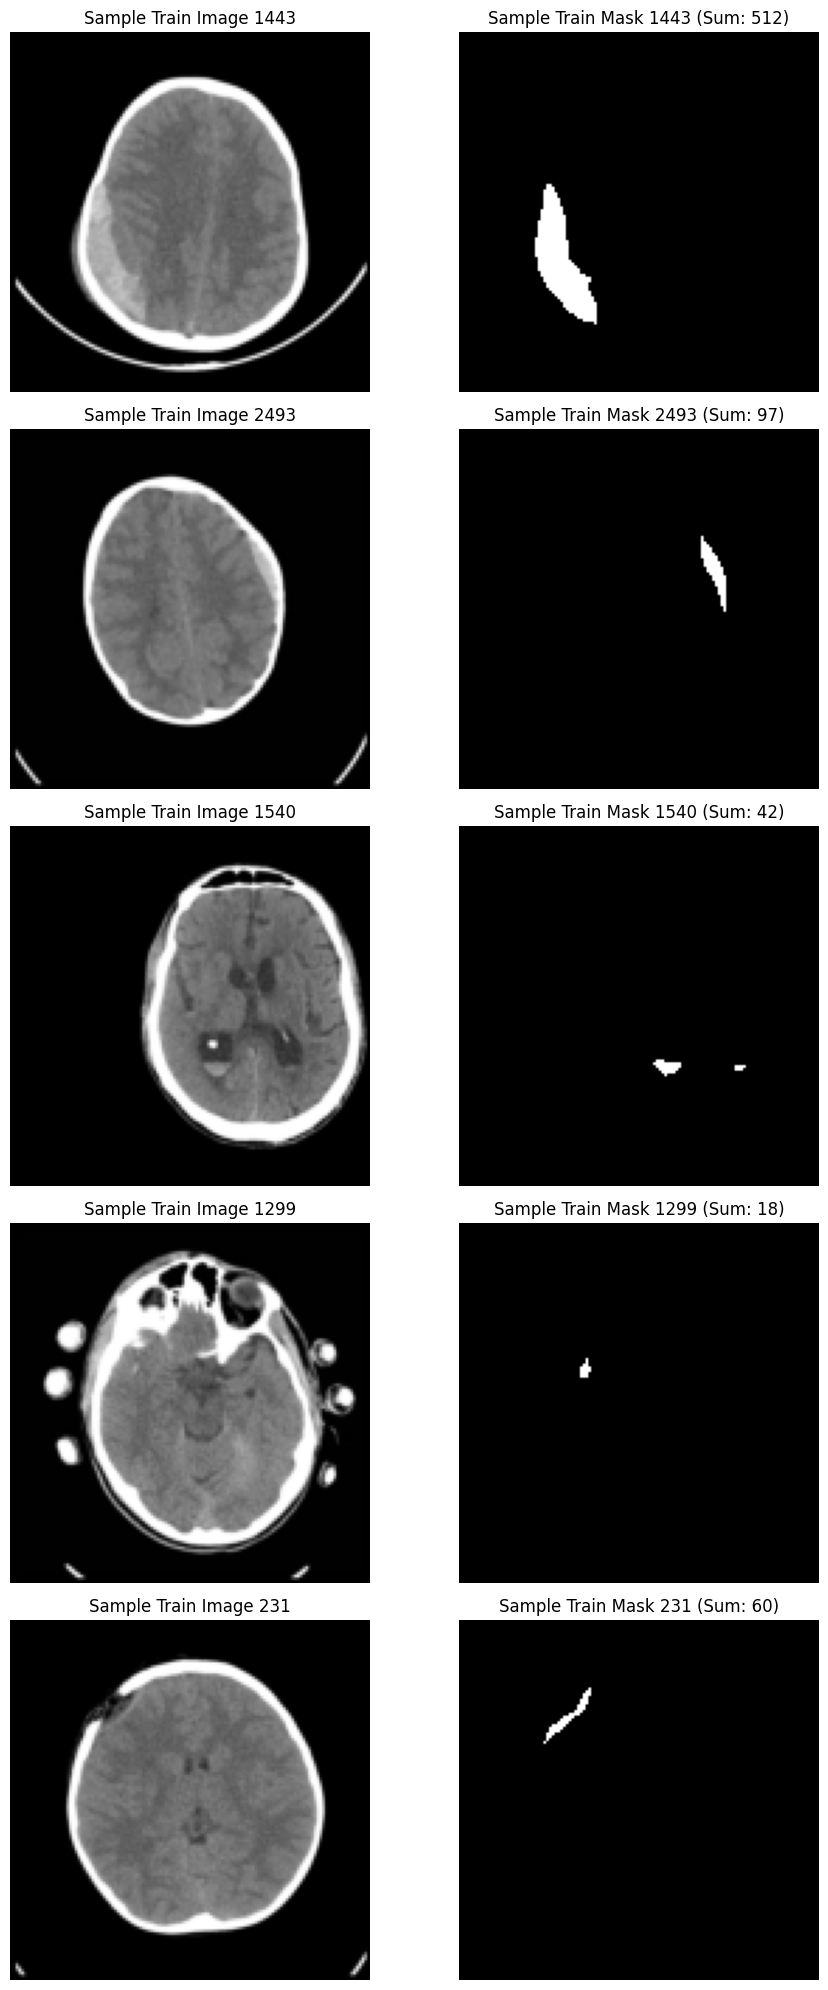


Displaying random samples with NON-EMPTY masks from VALIDATION set:


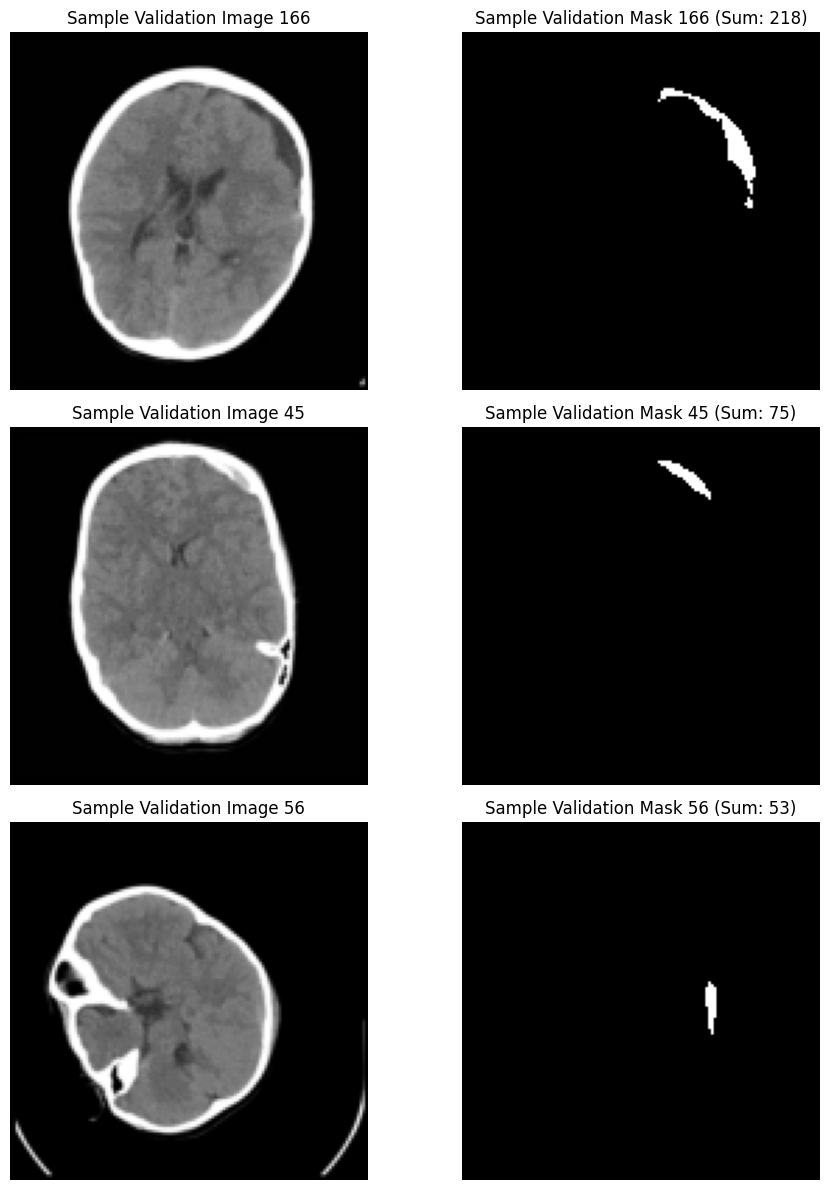

In [12]:
#------------------------------------
# Cell 8: Verify Loaded Data
#------------------------------------
import matplotlib.pyplot as plt # Ensure plt is imported
import numpy as np             # Ensure numpy is imported

# Display a few samples to ensure loading and preprocessing worked
# Try to find indices with non-empty masks if possible
non_empty_indices_train = np.where(np.sum(Y_train, axis=(1, 2, 3)) > 0)[0]

if len(non_empty_indices_train) > 0:
    print("Displaying random samples with NON-EMPTY masks from TRAINING set:")
    num_display = min(5, len(non_empty_indices_train)) # Show up to 5 non-empty samples
    indices_to_display = np.random.choice(non_empty_indices_train, num_display, replace=False)
else:
    print("Displaying random samples from TRAINING set (could be empty masks):")
    num_display = 5
    indices_to_display = np.random.randint(0, len(X_train), num_display)

plt.figure(figsize=(10, num_display * 4))
for i, idx in enumerate(indices_to_display):
    plt.subplot(num_display, 2, 2*i + 1)
    plt.imshow(X_train[idx].squeeze(), cmap='gray') # Use .squeeze() to remove channel dim for imshow
    plt.title(f"Sample Train Image {idx}")
    plt.axis('off')

    plt.subplot(num_display, 2, 2*i + 2)
    plt.imshow(Y_train[idx].squeeze(), cmap='gray') # Use .squeeze()
    plt.title(f"Sample Train Mask {idx} (Sum: {np.sum(Y_train[idx]):.0f})") # Show sum to confirm non-empty
    plt.axis('off')

plt.tight_layout()
plt.show()

# Optional: Display some validation samples too
non_empty_indices_val = np.where(np.sum(Y_val, axis=(1, 2, 3)) > 0)[0]
if len(non_empty_indices_val) > 0:
    print("\nDisplaying random samples with NON-EMPTY masks from VALIDATION set:")
    num_display_val = min(3, len(non_empty_indices_val)) # Show up to 3 non-empty samples
    indices_to_display_val = np.random.choice(non_empty_indices_val, num_display_val, replace=False)

    plt.figure(figsize=(10, num_display_val * 4))
    for i, idx in enumerate(indices_to_display_val):
        plt.subplot(num_display_val, 2, 2*i + 1)
        plt.imshow(X_val[idx].squeeze(), cmap='gray')
        plt.title(f"Sample Validation Image {idx}")
        plt.axis('off')

        plt.subplot(num_display_val, 2, 2*i + 2)
        plt.imshow(Y_val[idx].squeeze(), cmap='gray')
        plt.title(f"Sample Validation Mask {idx} (Sum: {np.sum(Y_val[idx]):.0f})")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

## 9. Model Definition: Building the U-Net Architecture

Here, we define the structure of our Artificial Neural Network using the Keras API within TensorFlow. We are using a **U-Net architecture**, which is very effective for biomedical image segmentation tasks.

*   **Structure**: It has an "encoder" path that progressively downsamples the image (using `Conv2D` for feature extraction and `MaxPooling2D` for reducing size), capturing context. It then has a "decoder" path that progressively upsamples (using `UpSampling2D`) and combines features from the encoder via "skip connections" (`concatenate`). These skip connections help the decoder use fine-grained details from earlier layers to create precise segmentations.
*   **Layers**: Uses standard deep learning layers like `Conv2D` (convolution), `ReLU` activation, `MaxPooling2D`, `UpSampling2D`, `concatenate`, and optional `Dropout` (to prevent overfitting).
*   **Output**: The final layer is a `Conv2D` with 1 filter and a `sigmoid` activation. This produces a single output map the same size as the input image, where each pixel value is between 0 and 1, representing the probability that the pixel belongs to the hemorrhage class.
*   **Summary**: `model.summary()` prints a table detailing the layers, shapes, and number of parameters in the defined model.

In [13]:
#------------------------------------
# Cell 9: Define Simple U-Net Model
#------------------------------------
import tensorflow as tf # Ensure tensorflow is imported
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Dropout
from tensorflow.keras.optimizers import Adam # Import Adam optimizer here or in Cell 10

# Make sure image dimensions are defined (usually from Cell 5)
# If you removed Cell 5 constants, define them here or get them from data shape
# Example assuming they were defined:
# IMG_HEIGHT = 128
# IMG_WIDTH = 128
# IMG_CHANNELS = 1
# Or get from data:
# IMG_HEIGHT = X_train.shape[1]
# IMG_WIDTH = X_train.shape[2]
# IMG_CHANNELS = X_train.shape[3]


# Basic U-Net Architecture (adapt complexity as needed)
def simple_unet_model(input_size=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)):
    """Defines a simple U-Net model architecture."""
    inputs = Input(input_size)

    # Encoder Path (Down-sampling)
    # Block 1
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(inputs)
    c1 = Dropout(0.1)(c1) # Optional Dropout
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    # Block 2
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Dropout(0.1)(c2) # Optional Dropout
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    # Block 3
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Dropout(0.2)(c3) # Optional Dropout
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    # Block 4 (Bottleneck) - Increased filters here
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = Dropout(0.2)(c4) # Optional Dropout
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)

    # Decoder Path (Up-sampling) & Skip Connections
    # Up-sample Block 1
    u6 = UpSampling2D((2, 2))(c4)
    u6 = concatenate([u6, c3]) # Skip connection from Encoder Block 3
    c6 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = Dropout(0.2)(c6) # Optional Dropout
    c6 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

    # Up-sample Block 2
    u7 = UpSampling2D((2, 2))(c6)
    u7 = concatenate([u7, c2]) # Skip connection from Encoder Block 2
    c7 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Dropout(0.1)(c7) # Optional Dropout
    c7 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

    # Up-sample Block 3
    u8 = UpSampling2D((2, 2))(c7)
    u8 = concatenate([u8, c1]) # Skip connection from Encoder Block 1
    c8 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = Dropout(0.1)(c8) # Optional Dropout
    c8 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)

    # Output layer
    # 1 filter because we have 1 output channel (binary mask)
    # Sigmoid activation squashes output between 0 and 1 (probability)
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c8)

    model = Model(inputs=[inputs], outputs=[outputs])

    return model

# Instantiate the model
# Ensure IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS are defined correctly before this line
input_shape = (IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)
model = simple_unet_model(input_size=input_shape)

# Print a summary of the model architecture (layers, parameters)
model.summary()

print("\nU-Net Model Defined and Summarized.")

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 128, 128, 1)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 128, 128, 16)   │            160 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 128, 128, 16)   │              0 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 128, 128, 16)   │          2,320 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 64, 64, 16)     │              0 │ conv2d_1[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 64, 64, 32)     │          4,640 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 64, 64, 32)     │              0 │ conv2d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 64, 64, 32)     │          9,248 │ dropout_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 32, 32, 32)     │              0 │ conv2d_3[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 32, 32, 64)     │         18,496 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, 32, 32, 64)     │              0 │ conv2d_4[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 32, 32, 64)     │         36,928 │ dropout_2[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_2           │ (None, 16, 16, 64)     │              0 │ conv2d_5[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_6 (Conv2D)         │ (None, 16, 16, 128)    │         73,856 │ max_pooling2d_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_3 (Dropout)       │ (None, 16, 16, 128)    │              0 │ conv2d_6[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_7 (Conv2D)         │ (None, 16, 16, 128)    │        147,584 │ dropout_3[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ up_sampling2d             │ (None, 32, 32, 128)    │              0 │ conv2d_7[0][0]         │
│ (UpSampling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concaten

 Total params: 487,009 (1.86 MB)

 Trainable params: 487,009 (1.86 MB)

 Non-trainable params: 0 (0.00 B)


U-Net Model Defined and Summarized.


## 10. Model Training: Compiling and Fitting the U-Net

This cell prepares the model for learning and then starts the training process.

1.  **Compile**: `model.compile()` configures the learning process:
    *   **Optimizer (`Adam`)**: Specifies the algorithm used to update the model's internal parameters (weights) based on the errors it makes. Adam with a defined `learning_rate` is a common starting point.
    *   **Loss Function (`dice_loss`)**: Defines the objective the model tries to minimize. Dice loss directly encourages overlap between the prediction and the true mask, suitable for segmentation.
    *   **Metrics (`dice_coef`, `binary_accuracy`)**: Specifies how to evaluate the model during training (doesn't affect learning, just for monitoring). We track the Dice score and standard pixel accuracy.
2.  **Train (`model.fit`)**: This is where the actual learning happens:
    *   The model iterates through the `X_train` and `Y_train` data multiple times (`EPOCHS`).
    *   It processes data in groups (`BATCH_SIZE`).
    *   After each epoch, it evaluates performance on the unseen `validation_data` (`X_val`, `Y_val`).
    *   This step heavily utilizes the **GPU** for acceleration.
    *   The results (loss and metrics per epoch) are stored in the `history` object.
3.  **Save Weights (Optional)**: Code is included (commented out) to save the trained model's parameters to a file, allowing reloading later without retraining.

In [14]:
#------------------------------------
# Cell 10: Compile and Train Model
#------------------------------------
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
# Dice loss and coef should be defined from Cell 6
# def dice_loss(y_true, y_pred): ...
# def dice_coef(y_true, y_pred, smooth=1e-6): ...

# Ensure the model variable holds the compiled U-Net from Cell 9
# model = simple_unet_model(...) # This was done at the end of Cell 9

# --- Compile the Model ---
# Choose your loss function and metrics. Dice loss/coef are good for segmentation.
# Adam optimizer is generally a good starting point. Learning rate might need tuning later.
LEARNING_RATE = 1e-4 # 0.0001

# Option 1: Using Dice Loss (often better for segmentation imbalance)
model.compile(optimizer=Adam(learning_rate=LEARNING_RATE),
              loss=dice_loss,
              metrics=[dice_coef, 'binary_accuracy']) # Monitor Dice and pixel accuracy

# Option 2: Using Binary Crossentropy (standard for binary problems)
# model.compile(optimizer=Adam(learning_rate=LEARNING_RATE),
#               loss=BinaryCrossentropy(),
#               metrics=[dice_coef, 'accuracy']) # Keras 'accuracy' is binary accuracy here

print("Model Compiled Successfully.")

# --- Define Training Parameters ---
# These might have been defined in Cell 5, ensure they are set correctly here
# EPOCHS = 5 # Start with few epochs for testing (e.g., 5-15) - Increase later for real training (50+)
# BATCH_SIZE = 16 # Adjust based on GPU memory (powers of 2 are common: 8, 16, 32)

# Check if EPOCHS and BATCH_SIZE are defined, if not, define them
if 'EPOCHS' not in locals(): EPOCHS = 10 # Default to 10 if not set
if 'BATCH_SIZE' not in locals(): BATCH_SIZE = 16 # Default to 16 if not set

print(f"Starting Training for {EPOCHS} epochs with Batch Size {BATCH_SIZE}...")

# --- Train the Model ---
# X_train, Y_train, X_val, Y_val should exist from the split in Cell 7
# The 'history' object will store training progress (loss, metrics per epoch)
history = model.fit(X_train, Y_train,
                    validation_data=(X_val, Y_val),
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    shuffle=True, # Shuffle training data each epoch
                    verbose=1)    # Show progress bar and metrics per epoch

print("\nTraining Finished.")

# --- Optional: Save Model Weights ---
# Good practice to save the weights after training
# You can load them later using model.load_weights('simple_unet_weights.h5')
# model.save_weights('simple_unet_prototype_weights.h5')
# print("Model weights saved to simple_unet_prototype_weights.h5")

Model Compiled Successfully.
Starting Training for 5 epochs with Batch Size 16...
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(None, 128, 128, 1))
  warnings.warn(msg)


159/159 ━━━━━━━━━━━━━━━━━━━━ 38s 131ms/step - binary_accuracy: 0.8609 - dice_coef: 0.0023 - loss: 0.9977 - val_binary_accuracy: 0.9990 - val_dice_coef: 3.6171e-09 - val_loss: 1.0000
Epoch 2/5
159/159 ━━━━━━━━━━━━━━━━━━━━ 14s 33ms/step - binary_accuracy: 0.9991 - dice_coef: 5.9651e-09 - loss: 1.0000 - val_binary_accuracy: 0.9990 - val_dice_coef: 3.6934e-09 - val_loss: 1.0000
Epoch 3/5
159/159 ━━━━━━━━━━━━━━━━━━━━ 10s 33ms/step - binary_accuracy: 0.9993 - dice_coef: 6.3245e-09 - loss: 1.0000 - val_binary_accuracy: 0.9990 - val_dice_coef: 3.6936e-09 - val_loss: 1.0000
Epoch 4/5
159/159 ━━━━━━━━━━━━━━━━━━━━ 6s 36ms/step - binary_accuracy: 0.9993 - dice_coef: 6.1951e-09 - loss: 1.0000 - val_binary_accuracy: 0.9990 - val_dice_coef: 3.6938e-09 - val_loss: 1.0000
Epoch 5/5
159/159 ━━━━━━━━━━━━━━━━━━━━ 10s 33ms/step - binary_accuracy: 0.9991 - dice_coef: 5.6900e-09 - loss: 1.0000 - val_binary_accuracy: 0.9990 - val_dice_coef: 3.6941e-09 - val_loss: 1.0000

Training Finished.


## 11. Training Evaluation: Plotting Learning Curves

After training, we visualize how the learning progressed using the `history` object saved from `model.fit()`.
*   **Loss Plot**: Shows the training loss and validation loss decreasing over epochs. Ideally, both should decrease and stabilize. A large gap where validation loss increases while training loss decreases indicates overfitting.
*   **Metric Plot**: Shows the training Dice coefficient (or accuracy) and validation Dice coefficient increasing over epochs. Higher values are better. Again, monitoring the gap helps assess overfitting.
*   These plots are essential for understanding the training dynamics and deciding if more training, less training, or other adjustments are needed.

Plotting training history...


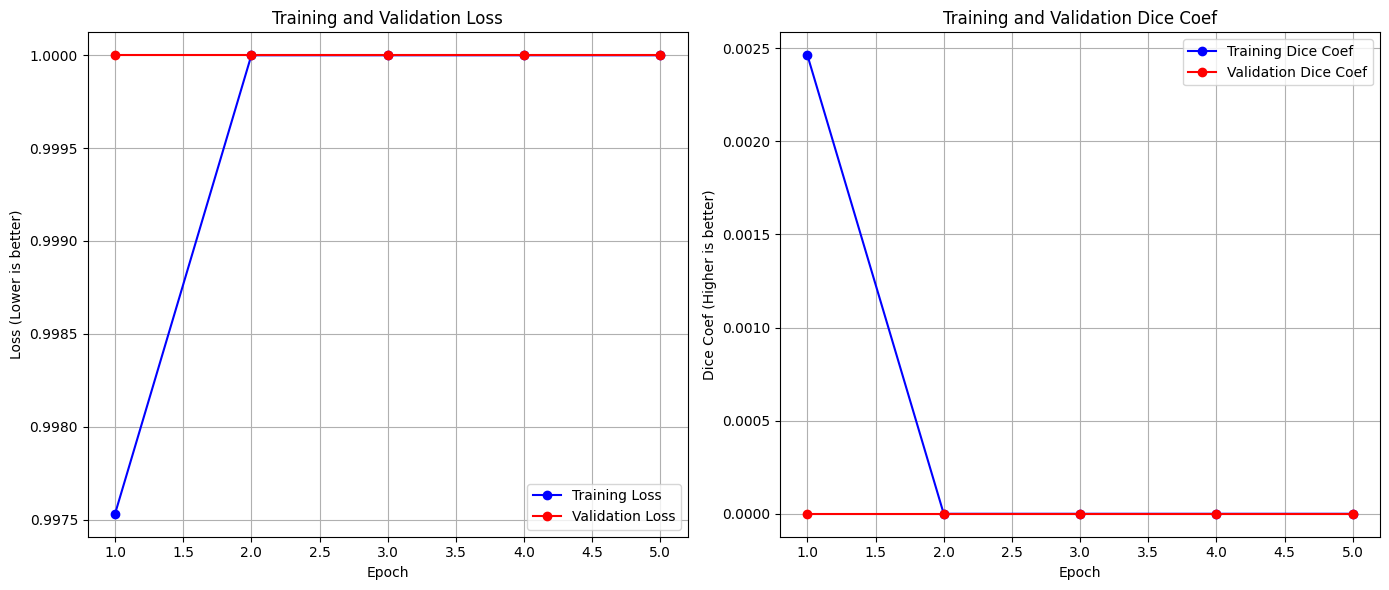

In [15]:
#------------------------------------
# Cell 11: Plot Training History
#------------------------------------
import matplotlib.pyplot as plt # Ensure pyplot is imported

# Check if the 'history' object exists from Cell 10
if 'history' not in locals():
    print("ERROR: 'history' object not found. Please run Cell 10 (model.fit) first.")
else:
    print("Plotting training history...")
    # Access the history data
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    # Use the actual metric names used during model.compile
    # Check history.history.keys() if unsure
    dice_coefficient_metric_name = 'dice_coef' # Name used in model.compile metrics
    if dice_coefficient_metric_name not in history.history:
        # If 'dice_coef' isn't present, maybe it was named differently or not included
        # Fall back to binary accuracy if Dice Coef isn't found
        dice_coefficient_metric_name = 'binary_accuracy'
        print(f"Warning: '{dice_coefficient_metric_name}' not found in history. Plotting 'binary_accuracy' instead.")

    if dice_coefficient_metric_name in history.history:
        dice_coef_values = history.history[dice_coefficient_metric_name]
        val_dice_coef_values = history.history['val_' + dice_coefficient_metric_name]

        epochs_range = range(1, len(loss) + 1) # Number of epochs trained

        plt.figure(figsize=(14, 6))

        # Plot Loss
        plt.subplot(1, 2, 1)
        plt.plot(epochs_range, loss, 'bo-', label='Training Loss')
        plt.plot(epochs_range, val_loss, 'ro-', label='Validation Loss')
        plt.title('Training and Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss (Lower is better)')
        plt.legend()
        plt.grid(True)

        # Plot Dice Coefficient (or binary accuracy if Dice wasn't available)
        plt.subplot(1, 2, 2)
        plt.plot(epochs_range, dice_coef_values, 'bo-', label=f'Training {dice_coefficient_metric_name.replace("_", " ").title()}')
        plt.plot(epochs_range, val_dice_coef_values, 'ro-', label=f'Validation {dice_coefficient_metric_name.replace("_", " ").title()}')
        plt.title(f'Training and Validation {dice_coefficient_metric_name.replace("_", " ").title()}')
        plt.xlabel('Epoch')
        plt.ylabel(f'{dice_coefficient_metric_name.replace("_", " ").title()} (Higher is better)')
        plt.legend()
        plt.grid(True)

        plt.tight_layout() # Adjust layout to prevent overlap
        plt.show()
    else:
        print(f"ERROR: Could not find metric '{dice_coefficient_metric_name}' or 'val_{dice_coefficient_metric_name}' in history object.")
        print("Available keys in history:", history.history.keys())

## 12. Model Evaluation: Predicting and Visualizing on Validation Set

This cell evaluates the final trained model's performance visually on data it has never seen during training (the validation set).

1.  **Predict**: `model.predict()` uses the trained model to generate output probability maps for the validation images (`X_val`).
2.  **Threshold**: Converts these probability maps (0.0-1.0) into binary masks (0 or 1) by applying a threshold (typically 0.5 for sigmoid output).
3.  **Visualize**: Displays a comparison for several validation samples:
    *   The original input image.
    *   The actual ground truth mask (`Y_val`).
    *   The mask predicted by the model (`preds_val_t`).
*   This side-by-side comparison gives a qualitative assessment of the model's segmentation ability. It prioritizes showing samples that actually contain hemorrhage in the ground truth.

Predicting on validation samples...


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(16, 128, 128, 1))
  warnings.warn(msg)


18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step
Visualizing some predictions vs ground truth...
Displaying random validation samples with NON-EMPTY true masks:


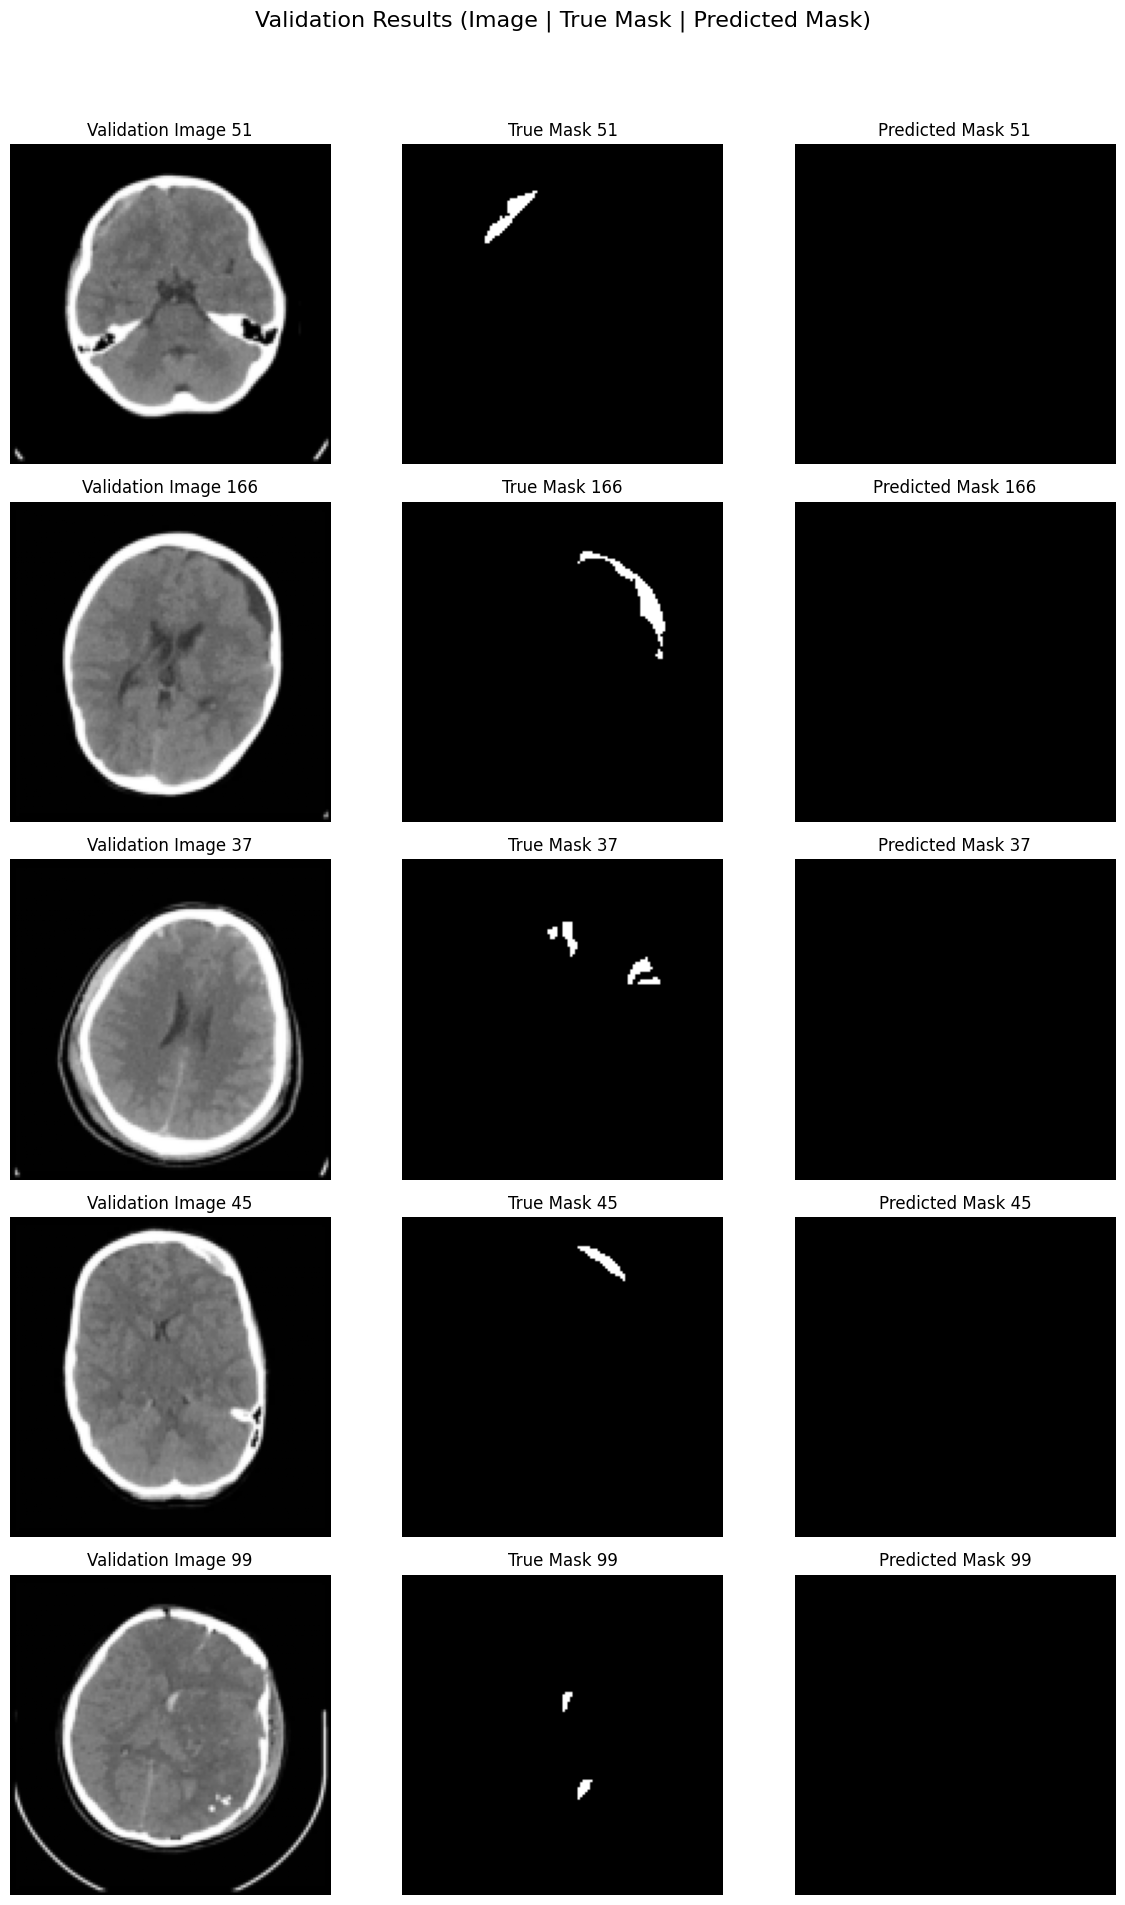

In [16]:
#------------------------------------
# Cell 12: Predict on Validation Data & Visualize
#------------------------------------
import matplotlib.pyplot as plt # Ensure plt is imported
import numpy as np             # Ensure numpy is imported

# Check if model, X_val, and Y_val exist
if 'model' not in locals():
    print("ERROR: 'model' object not found. Please define and train the model (Cells 9 & 10) first.")
elif 'X_val' not in locals() or 'Y_val' not in locals():
    print("ERROR: Validation data (X_val, Y_val) not found. Please run data loading and splitting (Cell 7) first.")
else:
    print("Predicting on validation samples...")
    # Predict on the entire validation set
    # This returns probabilities (0.0 to 1.0) due to the sigmoid output layer
    preds_val = model.predict(X_val, batch_size=BATCH_SIZE) # Use BATCH_SIZE if defined, otherwise set a value e.g., 16

    # Threshold predictions to get binary masks (0 or 1)
    # A threshold of 0.5 is standard for sigmoid outputs
    THRESHOLD = 0.5
    preds_val_t = (preds_val > THRESHOLD).astype(np.uint8) # Convert to unsigned integer 0 or 1

    print("Visualizing some predictions vs ground truth...")

    # --- Select samples to display ---
    # Prioritize displaying samples that HAVE a ground truth mask
    non_empty_indices_val = np.where(np.sum(Y_val, axis=(1, 2, 3)) > 0)[0]

    if len(non_empty_indices_val) > 0:
        print("Displaying random validation samples with NON-EMPTY true masks:")
        num_display = min(5, len(non_empty_indices_val)) # Show up to 5 non-empty samples
        indices_to_display = np.random.choice(non_empty_indices_val, num_display, replace=False)
    else:
        print("Warning: No non-empty masks found in validation set. Displaying random samples.")
        num_display = 5
        indices_to_display = np.random.randint(0, len(X_val), num_display)


    # --- Create Plots ---
    plt.figure(figsize=(12, num_display * 4)) # Width, Height
    plt.suptitle("Validation Results (Image | True Mask | Predicted Mask)", fontsize=16)

    for i, idx in enumerate(indices_to_display):
        # Original Validation Image
        plt.subplot(num_display, 3, 3*i + 1)
        plt.imshow(X_val[idx].squeeze(), cmap='gray')
        plt.title(f"Validation Image {idx}")
        plt.axis('off')

        # True Mask (Ground Truth)
        plt.subplot(num_display, 3, 3*i + 2)
        plt.imshow(Y_val[idx].squeeze(), cmap='gray')
        plt.title(f"True Mask {idx}")
        plt.axis('off')

        # Predicted Mask
        plt.subplot(num_display, 3, 3*i + 3)
        plt.imshow(preds_val_t[idx].squeeze(), cmap='gray')
        plt.title(f"Predicted Mask {idx}")
        plt.axis('off')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to make space for suptitle
    plt.show()

## 13. Conclusion: Reflection, Challenges & Next Steps

This final section summarizes the project, reflects on the process, and outlines potential future improvements (as detailed in the content above). It discusses the successes (like overcoming data loading issues) and the limitations (like short training time, potential for improvement via augmentation, hyperparameter tuning, or moving to 3D).

#------------------------------------
# Cell 13: Reflection, Challenges & Next Steps
#------------------------------------

## Reflection on Progress:

We successfully:
1.  Downloaded the target dataset ("Computed Tomography Images for Intracranial Hemorrhage Detection and Segmentation").
2.  Configured the Kaggle API correctly.
3.  Debugged the file path issues caused by the extra directory layer after unzipping.
4.  Identified the correct mask filename pattern (`_HGE_Seg.jpg`).
5.  Iteratively debugged the `load_mask` function, particularly the thresholding step, to ensure non-empty masks were correctly processed and loaded into the `Y_data` array.
6.  Confirmed the data loading was successful using visualization (Cell 8) and data checks (end of Cell 7).
7.  Defined a U-Net model architecture (Cell 9).
8.  Compiled and trained the model for a few epochs (Cell 10).
9.  Visualized the training progress (Cell 11).
10. Generated predictions on the validation set and visualized the results (Cell 12).

This demonstrates the core pipeline for a medical image segmentation task!

## Potential Challenges & Areas for Improvement:

1.  **Model Performance:**
    *   **Challenge:** The initial training (only 5-10 epochs) likely resulted in suboptimal segmentation performance (check Dice scores in Cell 10 output and visualizations in Cell 12). The predicted masks might be noisy, incomplete, or inaccurate.
    *   **Solutions:**
        *   **Train Longer:** Increase `EPOCHS` significantly (e.g., 50, 100, 200+) and monitor validation loss/metrics to see when performance plateaus or starts overfitting (validation loss increases while training loss decreases).
        *   **Hyperparameter Tuning:** Experiment with `LEARNING_RATE` (try smaller values like 1e-5), `BATCH_SIZE` (if memory allows), different optimizers (e.g., AdamW, SGD with momentum).
        *   **Model Architecture:** Try a deeper U-Net (more blocks/filters), or standard variants like ResUNet, Attention U-Net. Be mindful of computational cost.
        *   **Loss Function:** While Dice Loss is good, sometimes combined losses (e.g., Dice + Binary Crossentropy) work well. Focal Loss can also help with class imbalance if Dice isn't sufficient.

2.  **Data Quality & Quantity:**
    *   **Challenge:** The dataset has ~2800 slices with only 318 masks. This class imbalance (many more non-hemorrhage slices than hemorrhage slices) can make training difficult. The JPG format might introduce minor artifacts compared to lossless formats like PNG. The original resolution (650x650) was downsampled significantly (to 128x128), potentially losing fine details.
    *   **Solutions:**
        *   **Data Augmentation:** Use libraries like `ImageDataGenerator` (Keras) or `albumentations` to artificially increase the dataset size and variability by applying random rotations, flips, shifts, zooms, brightness/contrast changes *to both the image and the mask simultaneously*.
        *   **Weighted Loss:** Give more importance to the hemorrhage pixels during loss calculation (possible with custom loss functions or sometimes built-in arguments).
        *   **Larger Input Size:** If GPU memory allows, try increasing `IMG_HEIGHT`/`IMG_WIDTH` (e.g., to 256x256) to retain more detail, but this will require more memory and potentially a smaller batch size.
        *   **Find More Data:** Look for other compatible datasets to combine.

3.  **Evaluation Metrics:**
    *   **Challenge:** Dice coefficient is good, but doesn't tell the whole story.
    *   **Solutions:** Calculate additional segmentation metrics like Intersection over Union (IoU or Jaccard Index), Sensitivity (Recall), Specificity, Precision on the validation set (`sklearn.metrics` can help here after getting predictions).

4.  **Validation Strategy:**
    *   **Challenge:** The current `train_test_split` mixes slices from the same patient between training and validation. The model might implicitly learn patient-specific features rather than general hemorrhage patterns.
    *   **Solutions:** Implement a patient-level split. Group all slices by patient ID first, then split the *patient IDs* into training and validation sets, ensuring no patient overlap. This requires modifying the data preparation logic significantly.

5.  **Moving to 3D:**
    *   **Challenge:** The original project likely implies 3D segmentation for TBI analysis. This 2D slice-by-slice approach ignores volumetric context.
    *   **Solutions:**
        *   Explore 3D U-Net architectures (`Conv3D`, etc.).
        *   Requires loading data as volumes (e.g., stacking slices per patient, potentially using NIfTI format if available or converting DICOM stacks).
        *   Significantly higher memory requirements, often necessitating patch-based training (training on smaller 3D sub-volumes).
        *   Libraries like `SimpleITK` or `NiBabel` are essential for handling 3D medical data.

## Next Steps for This Prototype:

1.  **Train Longer:** Increase `EPOCHS` in Cell 10 (e.g., to 30 or 50) and re-run Cells 10, 11, 12 to see performance improvement.
2.  **Visualize More:** Modify Cell 12 to show more validation examples, including some where the true mask is *empty*, to see if the model correctly predicts nothing in those cases.
3.  **Save Model:** Uncomment the `model.save_weights()` line in Cell 10 after successful longer training.
4.  **Clean Notebook & Push to GitHub:** Remove excessive debug prints, ensure comments are clear, add explanations in Markdown cells, and upload the `.ipynb` file to a GitHub repository with a good README.md explaining the project, data, steps, and results (including sample prediction images).